In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -36]) # Column containing response actual values (temperature) at time t

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 3
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df) 

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 3
C:\Users\User
C:\Users\User\Modeling\
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
12
84
<class 'list'>
12
21
<class 'list'>
(84, 1, 1, 2151)
(11, 1, 1, 2151)
(10, 1, 1, 2151)
(84, 1, 2151)
(11, 1, 2151)
(10, 1, 2151)
(84, 2151)
(11, 2151)
(10, 2151)
[[0.39307412 0.69695044 0.32924264 ... 0.45747266 0.31713244 0.95078979]
 [0.45747266 0.51683609 0.42215989 ... 0.5246051  0.60753341 0.55194411]
 [0.38487242 0.62674714 0.3411641  ... 0.4954435  0.36968408 0.88061968]
 ...
 [0.54100851 0.46473952 0.46949509 ... 0.4936209  0.51123937 0.49696233]
 [0.44896719 0.51620076 0.3997195  ... 0.54009721 0.55103281 0.59629405]
 [0.46780073 0.52414231 0.42356241 ... 0.49696233 0.58961118 0.50880923]]
Fold 2:
12
84
<class 'list'>
12
21
<class 'list'>
(84, 1, 1, 2151)
(11, 1, 1, 2151)
(10, 1, 1, 2151)
(84, 1, 2151)
(11, 1, 2151)
(10, 1, 2151)
(84, 2151)
(11, 2151)
(10, 2151)
[[0.38166311 0.6

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

3
179
(84, 2151)
(11, 2151)


[I 2025-05-20 03:43:35,801] A new study created in memory with name: no-name-7bd0bfac-86ab-4ae5-a675-51d720d8e655
[I 2025-05-20 03:51:13,602] Trial 0 finished with value: 0.14239162504673003 and parameters: {'lr': 0.016498902341244695, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.30058015520145287}. Best is trial 0 with value: 0.14239162504673003.


Cross Validation Accuracies:
[0.13536295294761658, 0.1617080420255661, 0.09457162022590637, 0.18429197371006012, 0.13602353632450104]
Mean Cross Validation Accuracy:
0.14239162504673003
Standard Deviation of Cross Validation Accuracy:
0.030018230559190288


[I 2025-05-20 04:01:42,279] Trial 1 finished with value: 0.08767258450388908 and parameters: {'lr': 0.0015269258259032418, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.28338780717559975}. Best is trial 1 with value: 0.08767258450388908.


Cross Validation Accuracies:
[0.08164142072200775, 0.05632251873612404, 0.09474896639585495, 0.10562669485807419, 0.10002332180738449]
Mean Cross Validation Accuracy:
0.08767258450388908
Standard Deviation of Cross Validation Accuracy:
0.017573659444966055


[I 2025-05-20 04:14:03,619] Trial 2 finished with value: 0.08042540550231933 and parameters: {'lr': 0.018709313989052647, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23590962787497338}. Best is trial 2 with value: 0.08042540550231933.


Cross Validation Accuracies:
[0.06118521839380264, 0.06531652808189392, 0.08972983062267303, 0.10718289017677307, 0.07871256023645401]
Mean Cross Validation Accuracy:
0.08042540550231933
Standard Deviation of Cross Validation Accuracy:
0.016756683017261294


[I 2025-05-20 04:25:34,466] Trial 3 finished with value: 3.957438325881958 and parameters: {'lr': 0.6363545571212073, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.11715374022600114}. Best is trial 2 with value: 0.08042540550231933.


Cross Validation Accuracies:
[3.1884844303131104, 11.379100799560547, 2.0748636722564697, 0.9274132251739502, 2.217329502105713]
Mean Cross Validation Accuracy:
3.957438325881958
Standard Deviation of Cross Validation Accuracy:
3.7795629938578124


[I 2025-05-20 04:35:50,453] Trial 4 finished with value: 0.08142326772212982 and parameters: {'lr': 0.021783282174961588, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2581782022754031}. Best is trial 2 with value: 0.08042540550231933.


Cross Validation Accuracies:
[0.060831233859062195, 0.05897577852010727, 0.09333651512861252, 0.10882961004972458, 0.08514320105314255]
Mean Cross Validation Accuracy:
0.08142326772212982
Standard Deviation of Cross Validation Accuracy:
0.019156161398491092


[I 2025-05-20 04:45:36,200] Trial 5 finished with value: 0.0832136906683445 and parameters: {'lr': 0.0072094476517063685, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.42032262076579163}. Best is trial 2 with value: 0.08042540550231933.


Cross Validation Accuracies:
[0.06023729220032692, 0.05889137089252472, 0.09843030571937561, 0.11284704506397247, 0.08566243946552277]
Mean Cross Validation Accuracy:
0.0832136906683445
Standard Deviation of Cross Validation Accuracy:
0.021143167042135324


[I 2025-05-20 04:55:38,075] Trial 6 finished with value: 0.05900740772485733 and parameters: {'lr': 0.0036489632203882366, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13597348778037022}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.08664599806070328, 0.040029771625995636, 0.057761117815971375, 0.05413719266653061, 0.056462958455085754]
Mean Cross Validation Accuracy:
0.05900740772485733
Standard Deviation of Cross Validation Accuracy:
0.015203873210411351


[I 2025-05-20 05:05:35,180] Trial 7 finished with value: 0.5102383315563201 and parameters: {'lr': 0.0633144430853967, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.43712446880862543}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.9918165802955627, 0.6507022380828857, 0.2596700191497803, 0.27488279342651367, 0.3741200268268585]
Mean Cross Validation Accuracy:
0.5102383315563201
Standard Deviation of Cross Validation Accuracy:
0.27869432003128963


[I 2025-05-20 05:14:45,333] Trial 8 finished with value: 0.0844948373734951 and parameters: {'lr': 0.017558221444094992, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.13373143935530163}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.061415281146764755, 0.06459852308034897, 0.1038922592997551, 0.11376204341650009, 0.0788060799241066]
Mean Cross Validation Accuracy:
0.0844948373734951
Standard Deviation of Cross Validation Accuracy:
0.020946219355012452


[I 2025-05-20 05:22:55,895] Trial 9 finished with value: 0.07899764701724052 and parameters: {'lr': 0.005015057047812257, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.10102642720046134}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.06054069101810455, 0.05509595945477486, 0.0932067334651947, 0.10467660427093506, 0.08146824687719345]
Mean Cross Validation Accuracy:
0.07899764701724052
Standard Deviation of Cross Validation Accuracy:
0.018864573889056033


[I 2025-05-20 05:33:19,836] Trial 10 finished with value: 0.08097869753837586 and parameters: {'lr': 0.0011410069763988903, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1896153913252932}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.061136677861213684, 0.058373287320137024, 0.09369530528783798, 0.10906899720430374, 0.08261922001838684]
Mean Cross Validation Accuracy:
0.08097869753837586
Standard Deviation of Cross Validation Accuracy:
0.019277856094423347


[I 2025-05-20 05:42:23,472] Trial 11 finished with value: 0.08265231698751449 and parameters: {'lr': 0.003739566944058454, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.10348350349363213}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.06568155437707901, 0.05773463100194931, 0.0876985564827919, 0.11924653500318527, 0.08290030807256699]
Mean Cross Validation Accuracy:
0.08265231698751449
Standard Deviation of Cross Validation Accuracy:
0.021323980319140203


[I 2025-05-20 05:53:15,236] Trial 12 finished with value: 0.09297384470701217 and parameters: {'lr': 0.0034280038706051403, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17963221187033535}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.06567449122667313, 0.027472101151943207, 0.11826226115226746, 0.1384691745042801, 0.114991195499897]
Mean Cross Validation Accuracy:
0.09297384470701217
Standard Deviation of Cross Validation Accuracy:
0.040570496385443196


[I 2025-05-20 06:03:23,916] Trial 13 finished with value: 0.08153333291411399 and parameters: {'lr': 0.12959659607865737, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1790777937890244}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.0615331307053566, 0.05977809801697731, 0.09879840165376663, 0.10392729938030243, 0.08362973481416702]
Mean Cross Validation Accuracy:
0.08153333291411399
Standard Deviation of Cross Validation Accuracy:
0.018315379152073413


[I 2025-05-20 06:10:36,564] Trial 14 finished with value: 0.08390051797032357 and parameters: {'lr': 0.005093683491492935, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.36980648978022673}. Best is trial 6 with value: 0.05900740772485733.


Cross Validation Accuracies:
[0.061362266540527344, 0.058285366743803024, 0.10723846405744553, 0.10913730412721634, 0.08347918838262558]
Mean Cross Validation Accuracy:
0.08390051797032357
Standard Deviation of Cross Validation Accuracy:
0.02166029257228925


[I 2025-05-20 06:19:29,969] Trial 15 finished with value: 0.057770836353302005 and parameters: {'lr': 0.0024283527009392714, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4946970644384653}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.03419530391693115, 0.04224074259400368, 0.06103832647204399, 0.0739944577217102, 0.07738535106182098]
Mean Cross Validation Accuracy:
0.057770836353302005
Standard Deviation of Cross Validation Accuracy:
0.01706224552081716


[I 2025-05-20 06:27:35,451] Trial 16 finished with value: 0.08175105899572373 and parameters: {'lr': 0.001805711620612462, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4862677385605594}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.06122678518295288, 0.058352090418338776, 0.09412176162004471, 0.10948760062456131, 0.08556705713272095]
Mean Cross Validation Accuracy:
0.08175105899572373
Standard Deviation of Cross Validation Accuracy:
0.01952265050015611


[I 2025-05-20 06:36:24,191] Trial 17 finished with value: 0.1428259089589119 and parameters: {'lr': 0.05578815636707193, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3431021414081205}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.20828396081924438, 0.06504613906145096, 0.16275568306446075, 0.1547923982143402, 0.12325136363506317]
Mean Cross Validation Accuracy:
0.1428259089589119
Standard Deviation of Cross Validation Accuracy:
0.047451037384415196


[I 2025-05-20 06:44:20,605] Trial 18 finished with value: 0.08495443016290664 and parameters: {'lr': 0.0090294734785231, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4963666708010668}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.06699493527412415, 0.06882456690073013, 0.09191586822271347, 0.10842622071504593, 0.08861055970191956]
Mean Cross Validation Accuracy:
0.08495443016290664
Standard Deviation of Cross Validation Accuracy:
0.015462663420683908


[I 2025-05-20 06:52:51,884] Trial 19 finished with value: 0.08027208596467972 and parameters: {'lr': 0.002406977630541933, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3425765791851716}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.061021674424409866, 0.05674082413315773, 0.0946279838681221, 0.10676557570695877, 0.08220437169075012]
Mean Cross Validation Accuracy:
0.08027208596467972
Standard Deviation of Cross Validation Accuracy:
0.01916261547554968


[I 2025-05-20 07:00:43,951] Trial 20 finished with value: 0.5495354562997818 and parameters: {'lr': 0.2419234124606022, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.41737243669594265}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.7317867875099182, 0.7703353762626648, 0.3957027196884155, 0.6124710440635681, 0.23738135397434235]
Mean Cross Validation Accuracy:
0.5495354562997818
Standard Deviation of Cross Validation Accuracy:
0.20348647868720837


[I 2025-05-20 07:07:07,366] Trial 21 finished with value: 0.07966381087899208 and parameters: {'lr': 0.010374156188682473, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.13696616820389368}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.06126190349459648, 0.06216989457607269, 0.0874893069267273, 0.10519935935735703, 0.08219859004020691]
Mean Cross Validation Accuracy:
0.07966381087899208
Standard Deviation of Cross Validation Accuracy:
0.01651904980849441


[I 2025-05-20 07:13:29,071] Trial 22 finished with value: 0.08079123198986053 and parameters: {'lr': 0.0030196248639557566, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21309284727420108}. Best is trial 15 with value: 0.057770836353302005.


Cross Validation Accuracies:
[0.06255121529102325, 0.05635674297809601, 0.09339702874422073, 0.10500168800354004, 0.08664948493242264]
Mean Cross Validation Accuracy:
0.08079123198986053
Standard Deviation of Cross Validation Accuracy:
0.01848844981160665


[I 2025-05-20 07:19:59,344] Trial 23 finished with value: 0.02978089191019535 and parameters: {'lr': 0.0011348551204857181, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15187695788503414}. Best is trial 23 with value: 0.02978089191019535.


Cross Validation Accuracies:
[0.01972360350191593, 0.04651268944144249, 0.03594879060983658, 0.02541782148182392, 0.021301554515957832]
Mean Cross Validation Accuracy:
0.02978089191019535
Standard Deviation of Cross Validation Accuracy:
0.010100303157145723


[I 2025-05-20 07:27:03,128] Trial 24 finished with value: 0.03140725940465927 and parameters: {'lr': 0.0010073237924087023, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1520451566183022}. Best is trial 23 with value: 0.02978089191019535.


Cross Validation Accuracies:
[0.02656020037829876, 0.02300308458507061, 0.036771509796381, 0.03476900979876518, 0.03593249246478081]
Mean Cross Validation Accuracy:
0.03140725940465927
Standard Deviation of Cross Validation Accuracy:
0.00556198557763333


[I 2025-05-20 07:35:09,222] Trial 25 finished with value: 0.030074067041277887 and parameters: {'lr': 0.001143088083318733, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16182760527674817}. Best is trial 23 with value: 0.02978089191019535.


Cross Validation Accuracies:
[0.02790662832558155, 0.023599090054631233, 0.04719555750489235, 0.02736930176615715, 0.024299757555127144]
Mean Cross Validation Accuracy:
0.030074067041277887
Standard Deviation of Cross Validation Accuracy:
0.008722694061984447


[I 2025-05-20 07:44:02,046] Trial 26 finished with value: 0.029765262827277185 and parameters: {'lr': 0.0010823170377813882, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16686784140351446}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.028593776747584343, 0.023870252072811127, 0.03832860663533211, 0.03245215862989426, 0.025581520050764084]
Mean Cross Validation Accuracy:
0.029765262827277185
Standard Deviation of Cross Validation Accuracy:
0.0051802992438523075


[I 2025-05-20 07:52:33,560] Trial 27 finished with value: 0.03207561820745468 and parameters: {'lr': 0.0010542963166010738, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20136861369445908}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.028668222948908806, 0.03132813051342964, 0.03984197974205017, 0.03549179807305336, 0.02504795975983143]
Mean Cross Validation Accuracy:
0.03207561820745468
Standard Deviation of Cross Validation Accuracy:
0.005168050307752363


[I 2025-05-20 08:00:51,259] Trial 28 finished with value: 0.09051331132650375 and parameters: {'lr': 0.0017819505180618758, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1611656908920088}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.060306236147880554, 0.06263374537229538, 0.0951380506157875, 0.10683844238519669, 0.12765008211135864]
Mean Cross Validation Accuracy:
0.09051331132650375
Standard Deviation of Cross Validation Accuracy:
0.02591052083824733


[I 2025-05-20 08:09:13,528] Trial 29 finished with value: 0.07971128448843956 and parameters: {'lr': 0.0017497094945426713, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2259612086997695}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.060068484395742416, 0.057111576199531555, 0.09404585510492325, 0.10651630908250809, 0.08081419765949249]
Mean Cross Validation Accuracy:
0.07971128448843956
Standard Deviation of Cross Validation Accuracy:
0.019088174799785643


[I 2025-05-20 08:15:57,521] Trial 30 finished with value: 0.08084278553724289 and parameters: {'lr': 0.03864523868498937, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.25972887339088646}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.061510346829891205, 0.05805571377277374, 0.09634225815534592, 0.10326569527387619, 0.08503991365432739]
Mean Cross Validation Accuracy:
0.08084278553724289
Standard Deviation of Cross Validation Accuracy:
0.018185874974277854


[I 2025-05-20 08:23:14,553] Trial 31 finished with value: 0.03663732521235943 and parameters: {'lr': 0.00103078528181047, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1628655391565361}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.03228921443223953, 0.028734393417835236, 0.05721639096736908, 0.037506233900785446, 0.027440393343567848]
Mean Cross Validation Accuracy:
0.03663732521235943
Standard Deviation of Cross Validation Accuracy:
0.01086461139445055


[I 2025-05-20 08:30:06,182] Trial 32 finished with value: 0.033712266758084294 and parameters: {'lr': 0.001533716904195093, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15470923834112438}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.027325542643666267, 0.035731956362724304, 0.03863854706287384, 0.03528602793812752, 0.031579259783029556]
Mean Cross Validation Accuracy:
0.033712266758084294
Standard Deviation of Cross Validation Accuracy:
0.003902923818410506


[I 2025-05-20 08:39:58,517] Trial 33 finished with value: 0.041325132548809054 and parameters: {'lr': 0.0011361744875360703, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2422989586742607}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.029417164623737335, 0.037133682519197464, 0.045815035700798035, 0.05307511240243912, 0.041184667497873306]
Mean Cross Validation Accuracy:
0.041325132548809054
Standard Deviation of Cross Validation Accuracy:
0.007970055718258878


[I 2025-05-20 08:49:12,184] Trial 34 finished with value: 0.09736104011535644 and parameters: {'lr': 0.0018361927303040028, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2114091881264835}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.0643729642033577, 0.09460648894309998, 0.10378419607877731, 0.12071859836578369, 0.10332295298576355]
Mean Cross Validation Accuracy:
0.09736104011535644
Standard Deviation of Cross Validation Accuracy:
0.01853740850045242


[I 2025-05-20 08:58:08,402] Trial 35 finished with value: 0.08364588245749474 and parameters: {'lr': 0.005218948100074914, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.295713644938098}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.062012072652578354, 0.0628136619925499, 0.09769792854785919, 0.11056609451770782, 0.08513965457677841]
Mean Cross Validation Accuracy:
0.08364588245749474
Standard Deviation of Cross Validation Accuracy:
0.019112259458328215


[I 2025-05-20 09:05:29,014] Trial 36 finished with value: 0.04219934269785881 and parameters: {'lr': 0.0023484487259651994, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12359130292835498}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.03878610208630562, 0.03760630637407303, 0.04597093164920807, 0.053313709795475006, 0.03531966358423233]
Mean Cross Validation Accuracy:
0.04219934269785881
Standard Deviation of Cross Validation Accuracy:
0.0066004578333469155


[I 2025-05-20 09:15:05,491] Trial 37 finished with value: 0.08277290388941765 and parameters: {'lr': 0.0121482924850273, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15441854502572885}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.07040495425462723, 0.0571998693048954, 0.10439343750476837, 0.10127108544111252, 0.08059517294168472]
Mean Cross Validation Accuracy:
0.08277290388941765
Standard Deviation of Cross Validation Accuracy:
0.018007326190429118


[I 2025-05-20 09:23:34,579] Trial 38 finished with value: 0.03229060359299183 and parameters: {'lr': 0.0015003158778182555, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2770690241689515}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.03088652342557907, 0.023131240159273148, 0.04337025433778763, 0.03450780734419823, 0.02955719269812107]
Mean Cross Validation Accuracy:
0.03229060359299183
Standard Deviation of Cross Validation Accuracy:
0.006648482050042411


[I 2025-05-20 09:33:09,933] Trial 39 finished with value: 0.08660977557301522 and parameters: {'lr': 0.7091566456576509, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18767559875718903}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.07280685007572174, 0.05694239214062691, 0.0830979123711586, 0.13449354469776154, 0.08570817857980728]
Mean Cross Validation Accuracy:
0.08660977557301522
Standard Deviation of Cross Validation Accuracy:
0.025987211462128474


[I 2025-05-20 09:41:26,057] Trial 40 finished with value: 0.23015109896659852 and parameters: {'lr': 0.3911698626996268, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1360507166663584}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.23939038813114166, 0.19394928216934204, 0.24679765105247498, 0.2398025393486023, 0.23081563413143158]
Mean Cross Validation Accuracy:
0.23015109896659852
Standard Deviation of Cross Validation Accuracy:
0.018796997677653932


[I 2025-05-20 09:50:08,981] Trial 41 finished with value: 0.03176576644182205 and parameters: {'lr': 0.0010060269536563728, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20166169000861606}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.021817998960614204, 0.036170635372400284, 0.04308650270104408, 0.034331098198890686, 0.023422596976161003]
Mean Cross Validation Accuracy:
0.03176576644182205
Standard Deviation of Cross Validation Accuracy:
0.008033796379834104


[I 2025-05-20 09:59:27,571] Trial 42 finished with value: 0.035019027441740035 and parameters: {'lr': 0.0013451323518289078, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16741411720793523}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.02417001873254776, 0.026778073981404305, 0.04135909304022789, 0.052183594554662704, 0.03060435689985752]
Mean Cross Validation Accuracy:
0.035019027441740035
Standard Deviation of Cross Validation Accuracy:
0.010391558264938615


[I 2025-05-20 10:07:30,999] Trial 43 finished with value: 0.03269075006246567 and parameters: {'lr': 0.0010028441740379955, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.118787701752634}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.028747456148266792, 0.03118763118982315, 0.037151556462049484, 0.027823584154248238, 0.038543522357940674]
Mean Cross Validation Accuracy:
0.03269075006246567
Standard Deviation of Cross Validation Accuracy:
0.0043738306893251755


[I 2025-05-20 10:15:00,685] Trial 44 finished with value: 0.06409509442746639 and parameters: {'lr': 0.002195456137582512, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23071817354257496}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.06324153393507004, 0.022241953760385513, 0.0859348401427269, 0.11819718033075333, 0.030859963968396187]
Mean Cross Validation Accuracy:
0.06409509442746639
Standard Deviation of Cross Validation Accuracy:
0.03538643253519047


[I 2025-05-20 10:23:58,662] Trial 45 finished with value: 0.07989243194460868 and parameters: {'lr': 0.0035342822010626883, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.14653806320659093}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.0625060573220253, 0.054777469485998154, 0.10115253925323486, 0.1001654639840126, 0.08086062967777252]
Mean Cross Validation Accuracy:
0.07989243194460868
Standard Deviation of Cross Validation Accuracy:
0.018957704288809493


[I 2025-05-20 10:34:09,987] Trial 46 finished with value: 0.2503965586423874 and parameters: {'lr': 0.001400810531066961, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19999187131494853}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.26553821563720703, 0.22800081968307495, 0.27019739151000977, 0.18414948880672455, 0.30409687757492065]
Mean Cross Validation Accuracy:
0.2503965586423874
Standard Deviation of Cross Validation Accuracy:
0.0409763600081826


[I 2025-05-20 10:44:27,913] Trial 47 finished with value: 0.08181186318397522 and parameters: {'lr': 0.0029637122308387473, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10963730060792028}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.06483275443315506, 0.061373792588710785, 0.09250428527593613, 0.1101658046245575, 0.08018267899751663]
Mean Cross Validation Accuracy:
0.08181186318397522
Standard Deviation of Cross Validation Accuracy:
0.018038475490745994


[I 2025-05-20 10:53:42,217] Trial 48 finished with value: 0.07803238481283188 and parameters: {'lr': 0.006193214890773944, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17768968933666116}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.06087390333414078, 0.05662844330072403, 0.08370291441679001, 0.1047172099351883, 0.08423945307731628]
Mean Cross Validation Accuracy:
0.07803238481283188
Standard Deviation of Cross Validation Accuracy:
0.017523154357297652


[I 2025-05-20 11:02:43,821] Trial 49 finished with value: 0.08185959309339523 and parameters: {'lr': 0.0039151030255068775, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2493650012998442}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.06532493233680725, 0.05816354602575302, 0.0900508463382721, 0.11070892959833145, 0.08504971116781235]
Mean Cross Validation Accuracy:
0.08185959309339523
Standard Deviation of Cross Validation Accuracy:
0.01867862603508534


[I 2025-05-20 11:11:55,989] Trial 50 finished with value: 0.08256634399294853 and parameters: {'lr': 0.1054965558096545, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12128333565688473}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.06257952004671097, 0.057745564728975296, 0.0991380512714386, 0.11304822564125061, 0.08032035827636719]
Mean Cross Validation Accuracy:
0.08256634399294853
Standard Deviation of Cross Validation Accuracy:
0.02109196651577525


[I 2025-05-20 11:20:40,792] Trial 51 finished with value: 0.031480465084314346 and parameters: {'lr': 0.0013239248485855874, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19679906353067014}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.026077020913362503, 0.026662223041057587, 0.039404790848493576, 0.04271937161684036, 0.022538919001817703]
Mean Cross Validation Accuracy:
0.031480465084314346
Standard Deviation of Cross Validation Accuracy:
0.008018377273552327


[I 2025-05-20 11:30:01,331] Trial 52 finished with value: 0.03287669904530048 and parameters: {'lr': 0.0013745196754042896, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.17397551125105867}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.03454127535223961, 0.027930112555623055, 0.0348295234143734, 0.03716735169291496, 0.029915232211351395]
Mean Cross Validation Accuracy:
0.03287669904530048
Standard Deviation of Cross Validation Accuracy:
0.003412712737661609


[I 2025-05-20 11:39:01,954] Trial 53 finished with value: 0.049395196884870526 and parameters: {'lr': 0.00214785502941593, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2005063703014323}. Best is trial 26 with value: 0.029765262827277185.


Cross Validation Accuracies:
[0.04835763946175575, 0.05670607089996338, 0.05630172789096832, 0.05067960172891617, 0.03493094444274902]
Mean Cross Validation Accuracy:
0.049395196884870526
Standard Deviation of Cross Validation Accuracy:
0.007913151955091428


[I 2025-05-20 11:48:08,039] Trial 54 finished with value: 0.029273771494627 and parameters: {'lr': 0.0013309067617736994, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.21973765499503678}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.021793054416775703, 0.02215430699288845, 0.03817572444677353, 0.03153004124760628, 0.032715730369091034]
Mean Cross Validation Accuracy:
0.029273771494627
Standard Deviation of Cross Validation Accuracy:
0.006369152270817719


[I 2025-05-20 11:57:19,336] Trial 55 finished with value: 0.08008774742484093 and parameters: {'lr': 0.0026684775757421847, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13602069007184844}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.0605236254632473, 0.05668972432613373, 0.09305736422538757, 0.10791656374931335, 0.08225145936012268]
Mean Cross Validation Accuracy:
0.08008774742484093
Standard Deviation of Cross Validation Accuracy:
0.019378121582696663


[I 2025-05-20 12:07:25,670] Trial 56 finished with value: 0.033632374927401544 and parameters: {'lr': 0.001349708259787198, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21604037935191975}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.025678856298327446, 0.03441326320171356, 0.03626994043588638, 0.04215606302022934, 0.029643751680850983]
Mean Cross Validation Accuracy:
0.033632374927401544
Standard Deviation of Cross Validation Accuracy:
0.005646014009870565


[I 2025-05-20 12:17:34,748] Trial 57 finished with value: 0.0829249531030655 and parameters: {'lr': 0.026422810436896586, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14944502887818678}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.06649183481931686, 0.062180325388908386, 0.08993793278932571, 0.11089267581701279, 0.0851219967007637]
Mean Cross Validation Accuracy:
0.0829249531030655
Standard Deviation of Cross Validation Accuracy:
0.01753048404340837


[I 2025-05-20 12:25:46,419] Trial 58 finished with value: 0.052910099178552626 and parameters: {'lr': 0.0019150421104687791, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1740911309768783}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.07896677404642105, 0.04856358468532562, 0.06814991682767868, 0.042883481830358505, 0.02598673850297928]
Mean Cross Validation Accuracy:
0.052910099178552626
Standard Deviation of Cross Validation Accuracy:
0.018737635608060955


[I 2025-05-20 12:34:42,633] Trial 59 finished with value: 0.08524998351931572 and parameters: {'lr': 0.004512030034102083, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.18926396073881407}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.062487419694662094, 0.06793465465307236, 0.10743436217308044, 0.09991007298231125, 0.08848340809345245]
Mean Cross Validation Accuracy:
0.08524998351931572
Standard Deviation of Cross Validation Accuracy:
0.017524125310045387


[I 2025-05-20 12:45:12,693] Trial 60 finished with value: 0.10201700627803803 and parameters: {'lr': 0.001237982210165737, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.26685561229211663}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.09857194870710373, 0.08155892044305801, 0.10921061784029007, 0.11867957562208176, 0.10206396877765656]
Mean Cross Validation Accuracy:
0.10201700627803803
Standard Deviation of Cross Validation Accuracy:
0.012327150259719106


[I 2025-05-20 12:51:39,024] Trial 61 finished with value: 0.033955229446291924 and parameters: {'lr': 0.0010512637026301303, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19491900300531229}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.023770101368427277, 0.028506485745310783, 0.03908243402838707, 0.03913269564509392, 0.03928443044424057]
Mean Cross Validation Accuracy:
0.033955229446291924
Standard Deviation of Cross Validation Accuracy:
0.006556224648750528


[I 2025-05-20 12:59:04,983] Trial 62 finished with value: 0.035818621143698694 and parameters: {'lr': 0.0017095238983071512, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10049885906537687}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.045076146721839905, 0.03171171247959137, 0.04063674807548523, 0.027928413823246956, 0.03374008461833]
Mean Cross Validation Accuracy:
0.035818621143698694
Standard Deviation of Cross Validation Accuracy:
0.006202556108300307


[I 2025-05-20 13:06:41,752] Trial 63 finished with value: 0.07374352738261222 and parameters: {'lr': 0.0027764101459751785, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.21477851344967666}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.06493059545755386, 0.05030958727002144, 0.08910604566335678, 0.09521603584289551, 0.06915537267923355]
Mean Cross Validation Accuracy:
0.07374352738261222
Standard Deviation of Cross Validation Accuracy:
0.016400878448433718


[I 2025-05-20 13:14:15,075] Trial 64 finished with value: 0.03559490591287613 and parameters: {'lr': 0.001003786579245153, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22716658785766447}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.020862512290477753, 0.03069830685853958, 0.04162072762846947, 0.05219350755214691, 0.03259947523474693]
Mean Cross Validation Accuracy:
0.03559490591287613
Standard Deviation of Cross Validation Accuracy:
0.010600158610313437


[I 2025-05-20 13:20:24,895] Trial 65 finished with value: 0.04148430600762367 and parameters: {'lr': 0.0016443053565954402, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3322136201451015}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.04721951112151146, 0.033409882336854935, 0.04143952205777168, 0.04637817293405533, 0.03897444158792496]
Mean Cross Validation Accuracy:
0.04148430600762367
Standard Deviation of Cross Validation Accuracy:
0.005066364649617922


[I 2025-05-20 13:27:54,222] Trial 66 finished with value: 0.19904353469610214 and parameters: {'lr': 0.0013127944932770654, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14528120642123613}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.12167336791753769, 0.2839682698249817, 0.19101582467556, 0.19857257604599, 0.19998763501644135]
Mean Cross Validation Accuracy:
0.19904353469610214
Standard Deviation of Cross Validation Accuracy:
0.051505165953896544


[I 2025-05-20 13:37:56,224] Trial 67 finished with value: 0.08237634673714637 and parameters: {'lr': 0.0020872239706503665, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16684091451454092}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.031538162380456924, 0.06937705725431442, 0.1309421956539154, 0.06358053535223007, 0.11644378304481506]
Mean Cross Validation Accuracy:
0.08237634673714637
Standard Deviation of Cross Validation Accuracy:
0.036403343085337804


[I 2025-05-20 13:46:59,255] Trial 68 finished with value: 0.03350086398422718 and parameters: {'lr': 0.0012750221371608747, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.24360213320334356}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.034065499901771545, 0.024610154330730438, 0.044647298753261566, 0.031040074303746223, 0.03314129263162613]
Mean Cross Validation Accuracy:
0.03350086398422718
Standard Deviation of Cross Validation Accuracy:
0.006477519854568921


[I 2025-05-20 13:51:35,291] Trial 69 finished with value: 0.08354791477322579 and parameters: {'lr': 0.003167310369815307, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.187785215012322}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.07466567307710648, 0.07492396980524063, 0.1145530641078949, 0.1049753949046135, 0.04862147197127342]
Mean Cross Validation Accuracy:
0.08354791477322579
Standard Deviation of Cross Validation Accuracy:
0.02363717090179497


[I 2025-05-20 13:55:29,322] Trial 70 finished with value: 0.03794092498719692 and parameters: {'lr': 0.001636569350738483, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.12825754791688793}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.028850162401795387, 0.03646035119891167, 0.04122959449887276, 0.04671427235007286, 0.03645024448633194]
Mean Cross Validation Accuracy:
0.03794092498719692
Standard Deviation of Cross Validation Accuracy:
0.005913428152756423


[I 2025-05-20 13:59:23,356] Trial 71 finished with value: 0.033695143461227414 and parameters: {'lr': 0.0011683425663782628, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20806333592807352}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.026966877281665802, 0.033317308872938156, 0.04164889082312584, 0.03316085413098335, 0.033381786197423935]
Mean Cross Validation Accuracy:
0.033695143461227414
Standard Deviation of Cross Validation Accuracy:
0.004670290777226564


[I 2025-05-20 14:03:10,905] Trial 72 finished with value: 0.03381881937384605 and parameters: {'lr': 0.0010165230568934124, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16024480938209412}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.03957001119852066, 0.03379584103822708, 0.0413036122918129, 0.028013359755277634, 0.026411272585392]
Mean Cross Validation Accuracy:
0.03381881937384605
Standard Deviation of Cross Validation Accuracy:
0.005961106797213467


[I 2025-05-20 14:07:08,046] Trial 73 finished with value: 0.046679386496543886 and parameters: {'lr': 0.0019739449337877095, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.20341519076250458}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.043775588274002075, 0.03009100630879402, 0.0394396148622036, 0.07099632918834686, 0.049094393849372864]
Mean Cross Validation Accuracy:
0.046679386496543886
Standard Deviation of Cross Validation Accuracy:
0.013661381021541092


[I 2025-05-20 14:11:01,952] Trial 74 finished with value: 0.07371445074677467 and parameters: {'lr': 0.002418362777478907, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.18875556282493147}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.05238473042845726, 0.08578948676586151, 0.08841312676668167, 0.05746503174304962, 0.0845198780298233]
Mean Cross Validation Accuracy:
0.07371445074677467
Standard Deviation of Cross Validation Accuracy:
0.015476533314576291


[I 2025-05-20 14:16:05,033] Trial 75 finished with value: 0.08778023943305016 and parameters: {'lr': 0.0015085984920132761, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22115900543395553}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.08195458352565765, 0.05396081134676933, 0.10001134872436523, 0.11920284479856491, 0.08377160876989365]
Mean Cross Validation Accuracy:
0.08778023943305016
Standard Deviation of Cross Validation Accuracy:
0.021590466716034772


[I 2025-05-20 14:27:17,007] Trial 76 finished with value: 0.033176659047603606 and parameters: {'lr': 0.0012263185954684143, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.18047796350254874}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.02663356252014637, 0.0322013795375824, 0.040306560695171356, 0.024128450080752373, 0.04261334240436554]
Mean Cross Validation Accuracy:
0.033176659047603606
Standard Deviation of Cross Validation Accuracy:
0.007287247190508555


[I 2025-05-20 14:34:58,603] Trial 77 finished with value: 0.034660694748163225 and parameters: {'lr': 0.001663283505553651, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23601674031603315}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.022752724587917328, 0.039062030613422394, 0.03825448080897331, 0.035894304513931274, 0.03733993321657181]
Mean Cross Validation Accuracy:
0.034660694748163225
Standard Deviation of Cross Validation Accuracy:
0.006046270268715995


[I 2025-05-20 14:40:02,547] Trial 78 finished with value: 0.06982835158705711 and parameters: {'lr': 0.0011652724812330074, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.14372906668920338}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.04622400924563408, 0.05739922821521759, 0.0926261842250824, 0.10114622861146927, 0.05174610763788223]
Mean Cross Validation Accuracy:
0.06982835158705711
Standard Deviation of Cross Validation Accuracy:
0.02253515576031632


[I 2025-05-20 14:43:12,503] Trial 79 finished with value: 0.041180003061890603 and parameters: {'lr': 0.00202172694006249, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1563859219722788}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.02308662049472332, 0.037247709929943085, 0.04163671284914017, 0.06897694617509842, 0.03495202586054802]
Mean Cross Validation Accuracy:
0.041180003061890603
Standard Deviation of Cross Validation Accuracy:
0.015195392408796547


[I 2025-05-20 14:45:52,929] Trial 80 finished with value: 0.20732068121433259 and parameters: {'lr': 0.0014990469183465774, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.31589340704781277}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.16685590147972107, 0.20111417770385742, 0.1987055391073227, 0.2188543677330017, 0.25107342004776]
Mean Cross Validation Accuracy:
0.20732068121433259
Standard Deviation of Cross Validation Accuracy:
0.027558910858222173


[I 2025-05-20 14:49:53,833] Trial 81 finished with value: 0.03703118339180946 and parameters: {'lr': 0.00100054696084458, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.26930896733903975}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.029819123446941376, 0.03288692608475685, 0.036461569368839264, 0.03688497468829155, 0.04910332337021828]
Mean Cross Validation Accuracy:
0.03703118339180946
Standard Deviation of Cross Validation Accuracy:
0.0065615711236543745


[I 2025-05-20 14:53:35,150] Trial 82 finished with value: 0.08334219679236413 and parameters: {'lr': 0.013796068103086836, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2949464937821771}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.061415787786245346, 0.0555700808763504, 0.09846720099449158, 0.11483064293861389, 0.08642727136611938]
Mean Cross Validation Accuracy:
0.08334219679236413
Standard Deviation of Cross Validation Accuracy:
0.02227942329730007


[I 2025-05-20 14:56:55,484] Trial 83 finished with value: 0.02983146496117115 and parameters: {'lr': 0.001474140828212446, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.17060132342366316}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.019883155822753906, 0.021409152075648308, 0.0433838777244091, 0.030154746025800705, 0.03432639315724373]
Mean Cross Validation Accuracy:
0.02983146496117115
Standard Deviation of Cross Validation Accuracy:
0.008647323179978085


[I 2025-05-20 15:05:08,845] Trial 84 finished with value: 0.12465668767690659 and parameters: {'lr': 0.9078898463586651, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.17215467601087803}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.06828689575195312, 0.08773122727870941, 0.08647742867469788, 0.268467515707016, 0.11232037097215652]
Mean Cross Validation Accuracy:
0.12465668767690659
Standard Deviation of Cross Validation Accuracy:
0.07325631420401209


[I 2025-05-20 15:15:55,798] Trial 85 finished with value: 0.06228429637849331 and parameters: {'lr': 0.002412925553315527, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16273247011867598}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.025345904752612114, 0.04911768063902855, 0.09313943982124329, 0.11160088330507278, 0.03221757337450981]
Mean Cross Validation Accuracy:
0.06228429637849331
Standard Deviation of Cross Validation Accuracy:
0.034134961552916704


[I 2025-05-20 15:29:08,772] Trial 86 finished with value: 0.03053055964410305 and parameters: {'lr': 0.001214911019570643, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11401055494370566}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.0206017903983593, 0.02870018035173416, 0.03733193874359131, 0.0409829244017601, 0.02503596432507038]
Mean Cross Validation Accuracy:
0.03053055964410305
Standard Deviation of Cross Validation Accuracy:
0.00758461616024387


[I 2025-05-20 15:39:25,485] Trial 87 finished with value: 0.10023659616708755 and parameters: {'lr': 0.007955492001173337, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11251497784165015}. Best is trial 54 with value: 0.029273771494627.


Cross Validation Accuracies:
[0.07457762956619263, 0.0879342257976532, 0.11199187487363815, 0.12626178562641144, 0.10041746497154236]
Mean Cross Validation Accuracy:
0.10023659616708755
Standard Deviation of Cross Validation Accuracy:
0.01802920220708275


[I 2025-05-20 15:46:46,769] Trial 88 finished with value: 0.026739645376801492 and parameters: {'lr': 0.001431634964858197, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12576068505893612}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.019073443487286568, 0.02173822559416294, 0.032025836408138275, 0.033760637044906616, 0.027100084349513054]
Mean Cross Validation Accuracy:
0.026739645376801492
Standard Deviation of Cross Validation Accuracy:
0.005677198378239162


[I 2025-05-20 15:54:37,031] Trial 89 finished with value: 0.08362426832318307 and parameters: {'lr': 0.0014873482972138246, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12636829864273583}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.06292799115180969, 0.05920102819800377, 0.10621131211519241, 0.10857148468494415, 0.08120952546596527]
Mean Cross Validation Accuracy:
0.08362426832318307
Standard Deviation of Cross Validation Accuracy:
0.020799998468728938


[I 2025-05-20 16:01:21,876] Trial 90 finished with value: 0.29703893065452575 and parameters: {'lr': 0.04391049369054337, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1114963044111507}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.2302609384059906, 0.34313341975212097, 0.22159966826438904, 0.3945736587047577, 0.2956269681453705]
Mean Cross Validation Accuracy:
0.29703893065452575
Standard Deviation of Cross Validation Accuracy:
0.06601530322257348


[I 2025-05-20 16:08:45,846] Trial 91 finished with value: 0.0361131489276886 and parameters: {'lr': 0.0011935509043688114, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.38089561039815495}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.03985753282904625, 0.02484365552663803, 0.044795602560043335, 0.04334767535328865, 0.027721278369426727]
Mean Cross Validation Accuracy:
0.0361131489276886
Standard Deviation of Cross Validation Accuracy:
0.008236124786140464


[I 2025-05-20 16:14:40,552] Trial 92 finished with value: 0.03052234835922718 and parameters: {'lr': 0.001924828076140705, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14003357667849942}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.02532213181257248, 0.02270720899105072, 0.04017875716090202, 0.040338270366191864, 0.024065373465418816]
Mean Cross Validation Accuracy:
0.03052234835922718
Standard Deviation of Cross Validation Accuracy:
0.007992618294992843


[I 2025-05-20 16:22:02,428] Trial 93 finished with value: 0.03426878787577152 and parameters: {'lr': 0.0019417018192951253, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13346852688823949}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.024603016674518585, 0.0262442659586668, 0.037945475429296494, 0.04336900636553764, 0.03918217495083809]
Mean Cross Validation Accuracy:
0.03426878787577152
Standard Deviation of Cross Validation Accuracy:
0.007460475392228333


[I 2025-05-20 16:30:01,556] Trial 94 finished with value: 0.029994384571909904 and parameters: {'lr': 0.0014327666839377342, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14018806564078956}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.029762588441371918, 0.027848584577441216, 0.03389491140842438, 0.02835729531943798, 0.03010854311287403]
Mean Cross Validation Accuracy:
0.029994384571909904
Standard Deviation of Cross Validation Accuracy:
0.002124400624072491


[I 2025-05-20 16:36:56,867] Trial 95 finished with value: 0.030522055551409723 and parameters: {'lr': 0.002664084943642027, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14008291322606126}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.02867176942527294, 0.02608170360326767, 0.04363951086997986, 0.0289301797747612, 0.025287114083766937]
Mean Cross Validation Accuracy:
0.030522055551409723
Standard Deviation of Cross Validation Accuracy:
0.00671038894348984


[I 2025-05-20 16:46:04,603] Trial 96 finished with value: 0.08582955896854401 and parameters: {'lr': 0.0039501128371526644, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13778410860037962}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.06539856642484665, 0.07274036854505539, 0.09093411266803741, 0.12028577923774719, 0.07978896796703339]
Mean Cross Validation Accuracy:
0.08582955896854401
Standard Deviation of Cross Validation Accuracy:
0.019175654803011834


[I 2025-05-20 16:53:00,552] Trial 97 finished with value: 0.03498112298548221 and parameters: {'lr': 0.0017756032466955385, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12255644202052322}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.025110376998782158, 0.039362698793411255, 0.0391429141163826, 0.03795655816793442, 0.03333306685090065]
Mean Cross Validation Accuracy:
0.03498112298548221
Standard Deviation of Cross Validation Accuracy:
0.0053948056843510445


[I 2025-05-20 16:57:31,031] Trial 98 finished with value: 0.03640888519585132 and parameters: {'lr': 0.002854787214924045, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1061975032866675}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.02706051431596279, 0.03819885104894638, 0.05575413629412651, 0.03317531198263168, 0.027855612337589264]
Mean Cross Validation Accuracy:
0.03640888519585132
Standard Deviation of Cross Validation Accuracy:
0.010473292015709726


[I 2025-05-20 17:01:47,114] Trial 99 finished with value: 0.033510484546422956 and parameters: {'lr': 0.0025443404785479426, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14479699431385373}. Best is trial 88 with value: 0.026739645376801492.


Cross Validation Accuracies:
[0.025924094021320343, 0.03100569359958172, 0.03852491453289986, 0.04304639995098114, 0.029051320627331734]
Mean Cross Validation Accuracy:
0.033510484546422956
Standard Deviation of Cross Validation Accuracy:
0.00632122824198333
Number of finished trials: 100
Best trial: {'lr': 0.001431634964858197, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12576068505893612}
Best hyperparameters:  {'lr': 0.001431634964858197, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12576068505893612}
Fold 1:
Epoch 1/100
84/84 [==============================] - 20s 109ms/step - loss: 0.1704 - val_loss: 0.1349
Epoch 2/100
84/84 [==============================] - 5s 55ms/step - loss: 0.1100 - val_loss: 0.0800
Epoch 3/100
84/84 [==============================] - 4s 51ms/step - loss: 0.0906 - val_loss: 0.0787
Epoch 4/100
84/84 [==============================] - 2s 29m

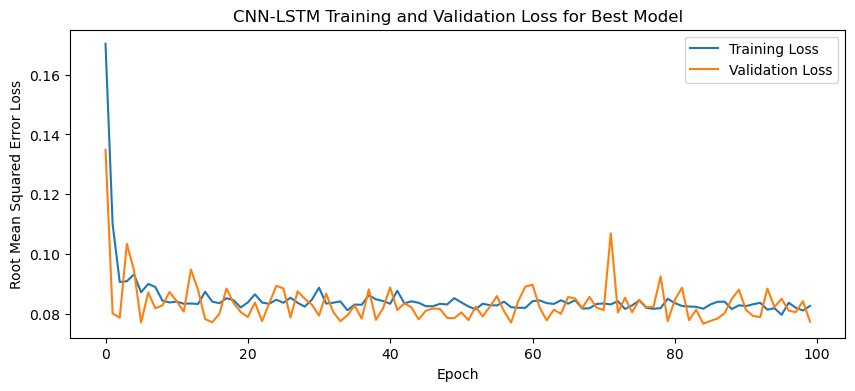

1/1 - 2s - loss: 0.0640 - 2s/epoch - 2s/step
Test Loss: 0.06403835862874985
1/1 [==============================] - 0s 86ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    #print("Forecasts:")
    #print(forecasts)
    #print("Actual:")
    #print(actual)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

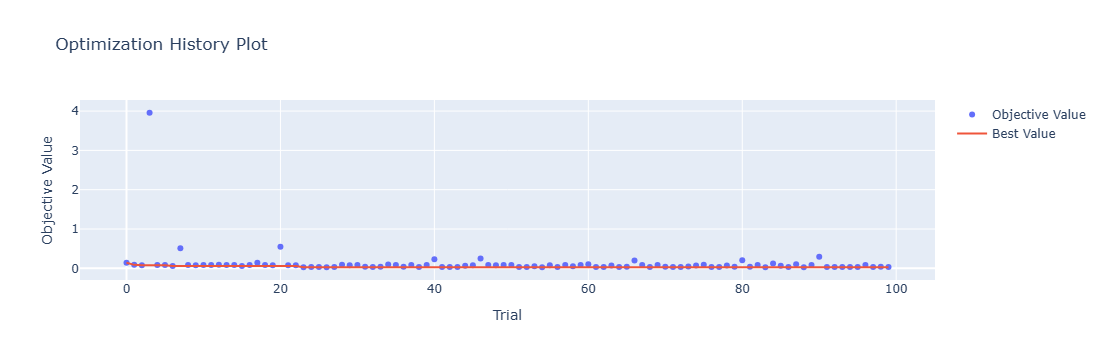

In [4]:
optuna.visualization.plot_optimization_history(study)

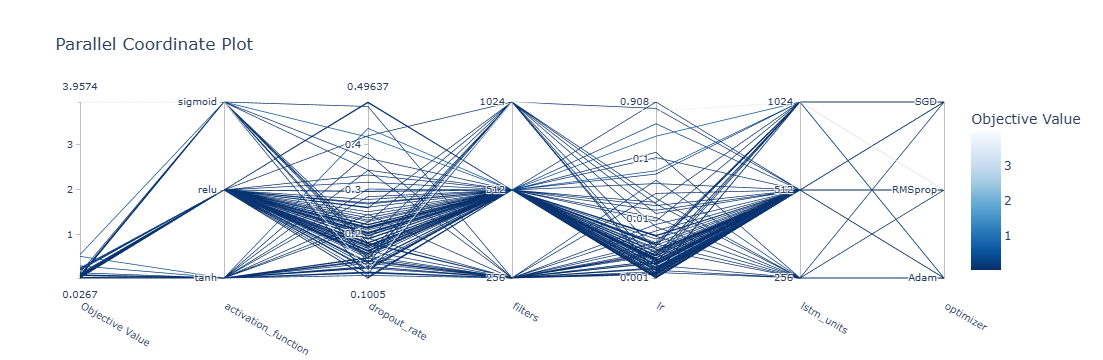

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

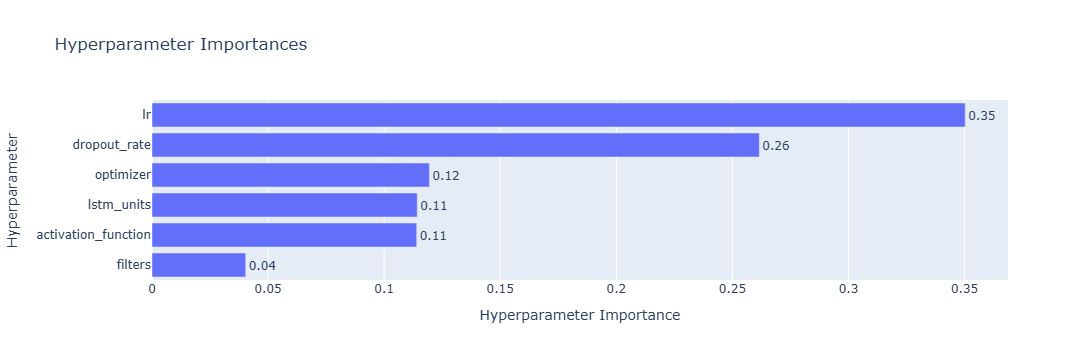

In [6]:
optuna.visualization.plot_param_importances(study)

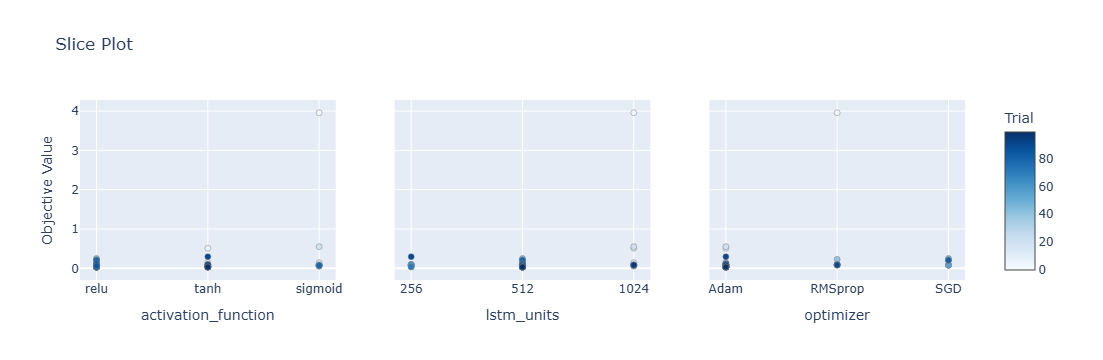

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

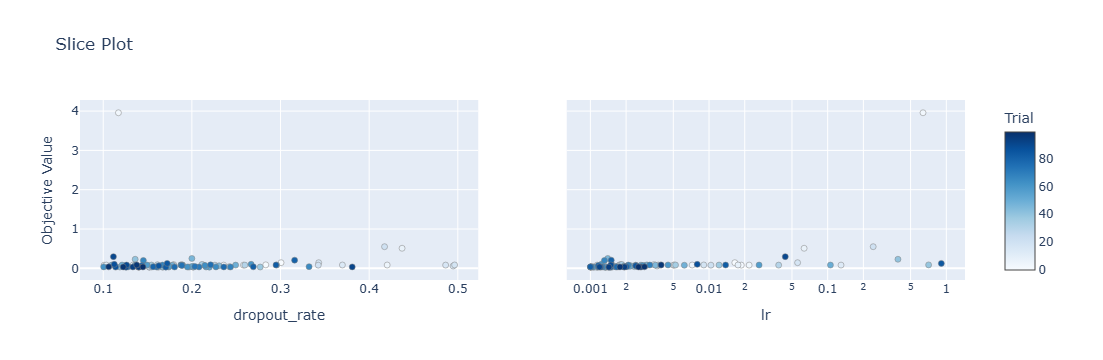

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 30s 154ms/step - loss: 0.1673 - accuracy: 0.8690 - mae: 0.1430 - rmse: 0.1673 - mape: 27.5221 - pearson: 0.7711 - val_loss: 0.1423 - val_accuracy: 1.0000 - val_mae: 0.1198 - val_rmse: 0.1423 - val_mape: 23.4150 - val_pearson: 0.9033
Epoch 2/100
84/84 [==============================] - 7s 79ms/step - loss: 0.1060 - accuracy: 0.8929 - mae: 0.0911 - rmse: 0.1060 - mape: 16.8965 - pearson: 0.8627 - val_loss: 0.0818 - val_accuracy: 1.0000 - val_mae: 0.0668 - val_rmse: 0.0818 - val_mape: 13.2526 - val_pearson: 0.9294
Epoch 3/100
84/84 [==============================] - 7s 89ms/step - loss: 0.0969 - accuracy: 0.8929 - mae: 0.0825 - rmse: 0.0969 - mape: 15.5453 - pearson: 0.8598 - val_loss: 0.0773 - val_accuracy: 1.0000 - val_mae: 0.0657 - val_rmse: 0.0773 - val_mape: 12.3732 - val_pearson: 0.9287
Epoch 4/100
84/84 [==============================] - 7s 80ms/step - loss: 0.0930 - accuracy: 0.8929 - mae: 0.0788 - rmse: 0.0930 - mape: 14.5634 -

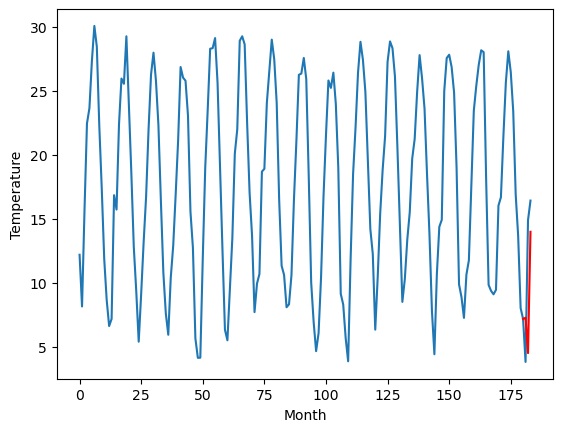

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		6.31		-2.22
8.44		3.55		-4.89
13.50		13.02		-0.48
[180, 181, 182, 183]
[13.23, 6.309053535461426, 3.5489913177490235, 13.023030395507813]


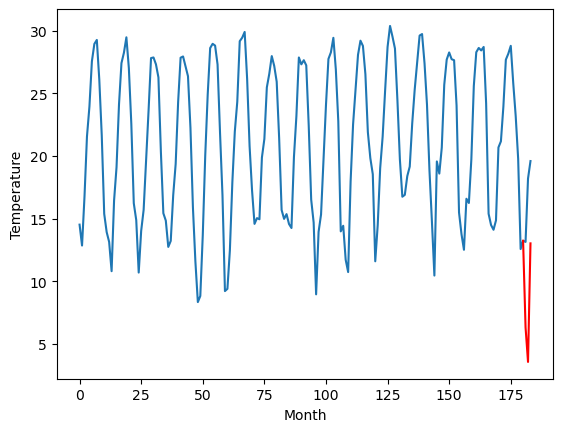

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.31		4.93		-2.38
8.17		2.17		-6.00
14.15		11.64		-2.51
[180, 181, 182, 183]
[7.18, 4.929051628112793, 2.168987503051758, 11.643026580810547]


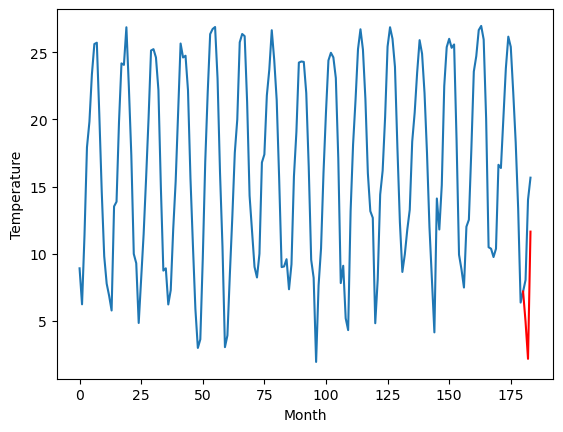

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.38		3.73		-1.65
3.81		0.97		-2.84
11.72		10.44		-1.28
[180, 181, 182, 183]
[11.46, 3.7290496015548706, 0.9689854764938355, 10.44302264690399]


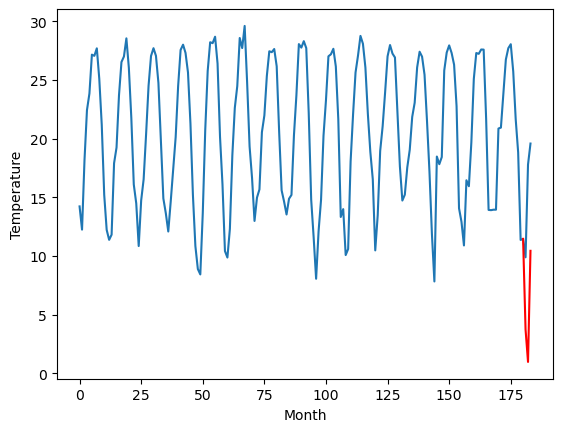

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.33		10.65		-0.68
8.24		7.89		-0.35
18.14		17.36		-0.78
[180, 181, 182, 183]
[9.27, 10.649050674438477, 7.888986549377442, 17.363027534484864]


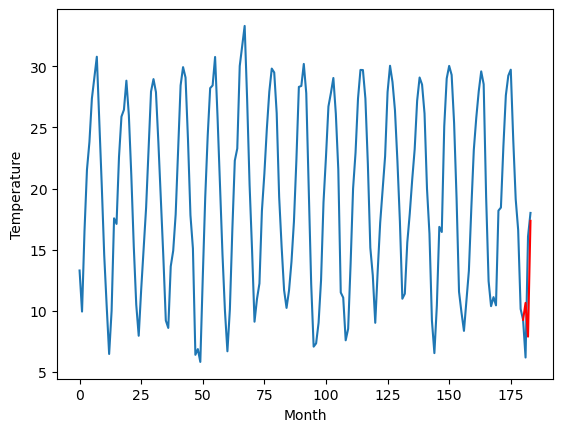

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.74		12.96		0.22
13.39		10.20		-3.19
18.29		19.67		1.38
[180, 181, 182, 183]
[7.77, 12.959052581787109, 10.198990364074707, 19.67303325653076]


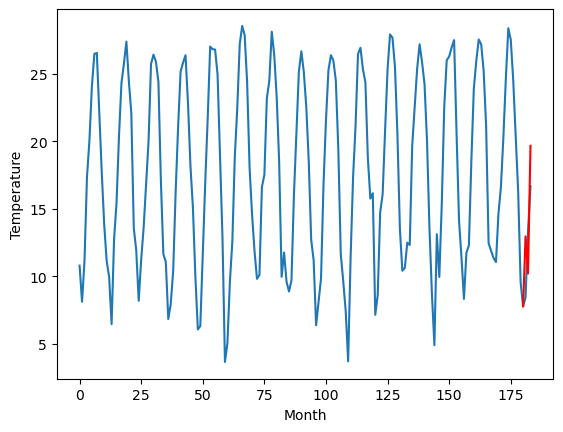

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.33		7.35		-0.98
8.97		4.59		-4.38
15.95		14.06		-1.89
[180, 181, 182, 183]
[6.59, 7.349051628112793, 4.588987503051758, 14.063026580810547]


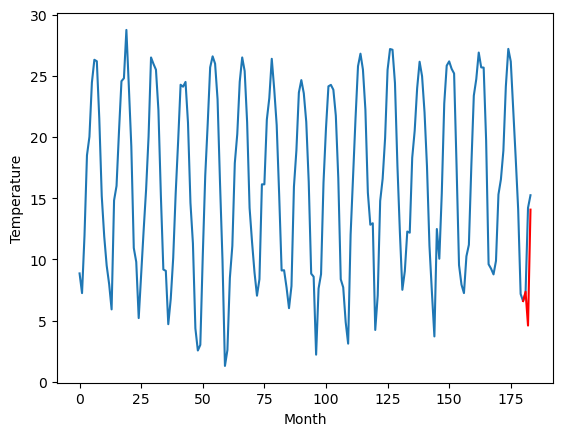

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.29		12.67		-0.62
13.91		9.91		-4.00
20.43		19.38		-1.05
[180, 181, 182, 183]
[5.3, 12.669051628112793, 9.908987503051758, 19.383026580810547]


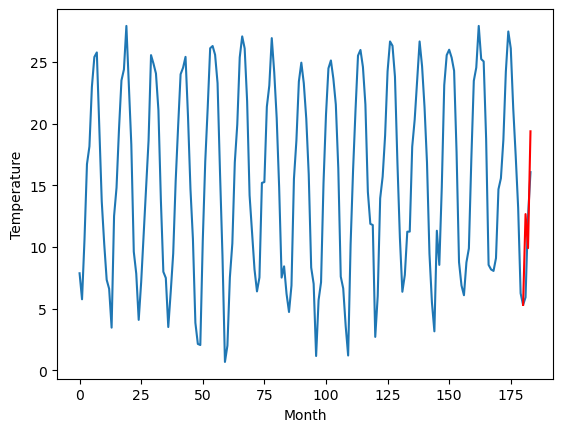

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.51		11.74		-0.77
8.24		8.98		0.74
20.71		18.45		-2.26
[180, 181, 182, 183]
[3.1, 11.739048647880555, 8.978986430168153, 18.45302550792694]


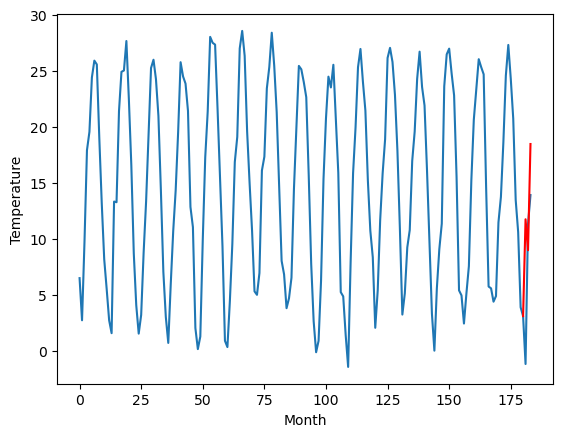

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.20		9.23		0.03
7.03		6.47		-0.56
17.78		15.94		-1.84
[180, 181, 182, 183]
[0.6, 9.229048647880553, 6.468982377052306, 15.943023362159728]


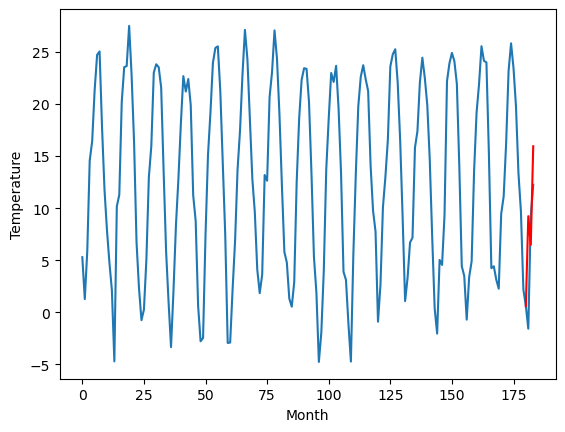

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.24		7.29		0.05
2.93		4.53		1.60
14.66		14.00		-0.66
[180, 181, 182, 183]
[-0.75, 7.289048647880554, 4.528982377052307, 14.003025269508361]


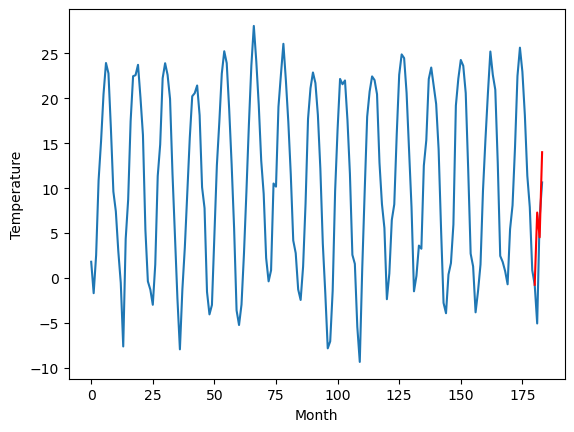

RangeIndex(start=1, stop=12, step=1)
[7.989999999999999, 8.53, 7.310000000000001, 5.3800000000000034, 11.33, 12.739999999999998, 8.33, 13.29, 12.51, 9.2, 7.24]
[7.289050674438476, 6.309053535461426, 4.929051628112793, 3.7290496015548706, 10.649050674438477, 12.959052581787109, 7.349051628112793, 12.669051628112793, 11.739048647880555, 9.229048647880553, 7.289048647880554]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.99   7.289051
1                 1    8.53   6.309054
2                 2    7.31   4.929052
3                 3    5.38   3.729050
4                 4   11.33  10.649051
5                 5   12.74  12.959053
6                 6    8.33   7.349052
7                 7   13.29  12.669052
8                 8   12.51  11.739049
9                 9    9.20   9.229049
10               10    7.24   7.289049


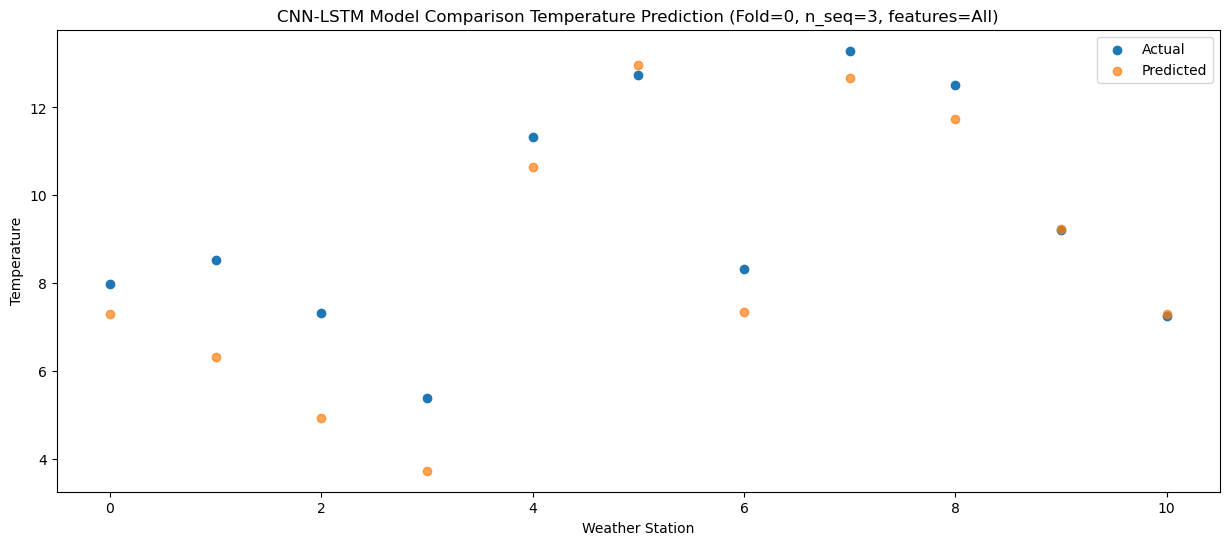

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.64   4.528987
1                 1    8.44   3.548991
2                 2    8.17   2.168988
3                 3    3.81   0.968985
4                 4    8.24   7.888987
5                 5   13.39  10.198990
6                 6    8.97   4.588988
7                 7   13.91   9.908988
8                 8    8.24   8.978986
9                 9    7.03   6.468982
10               10    2.93   4.528982


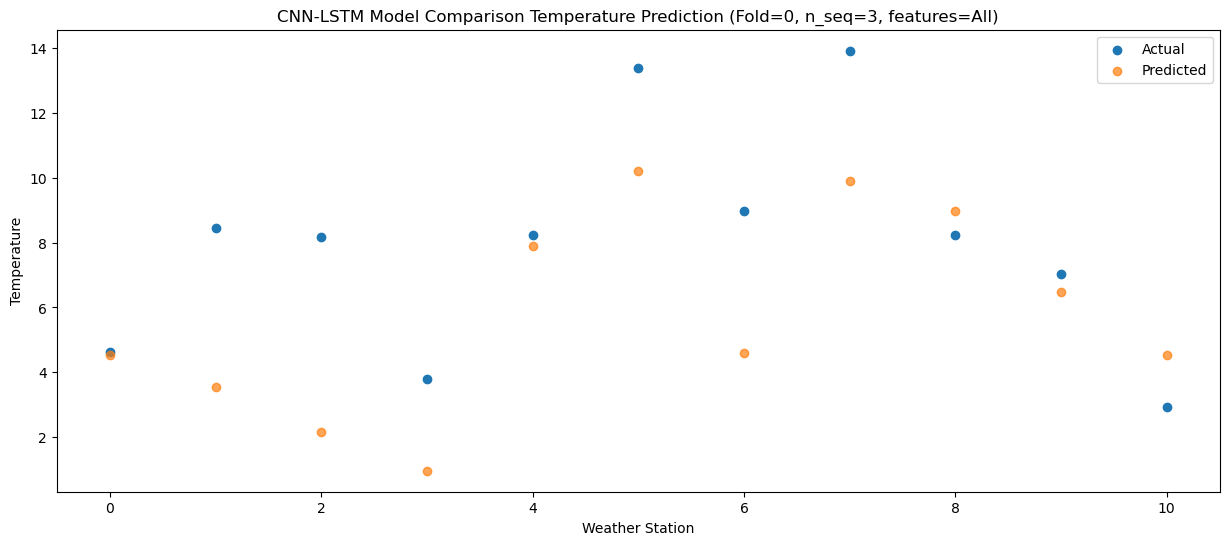

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   15.71  14.003029
1                 1   13.50  13.023030
2                 2   14.15  11.643027
3                 3   11.72  10.443023
4                 4   18.14  17.363028
5                 5   18.29  19.673033
6                 6   15.95  14.063027
7                 7   20.43  19.383027
8                 8   20.71  18.453026
9                 9   17.78  15.943023
10               10   14.66  14.003025


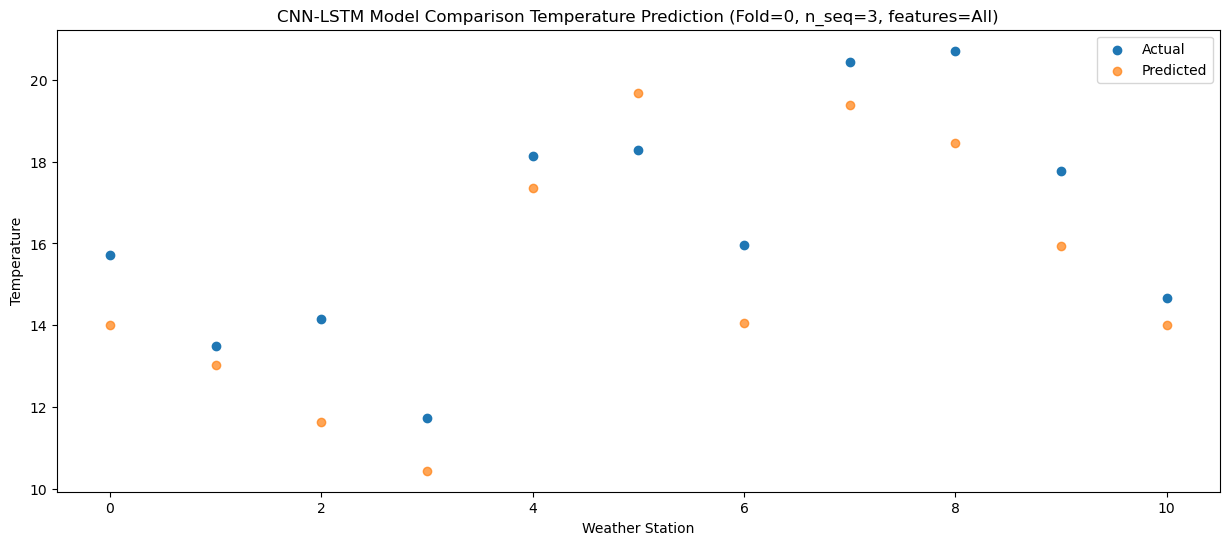

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1, 256)            550144    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_10 (LSTM)              (None, 1, 512)            1574912   
                                                                 
 dropout_16 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_11 (LSTM)              (None, 512)               2099200   
                                                      

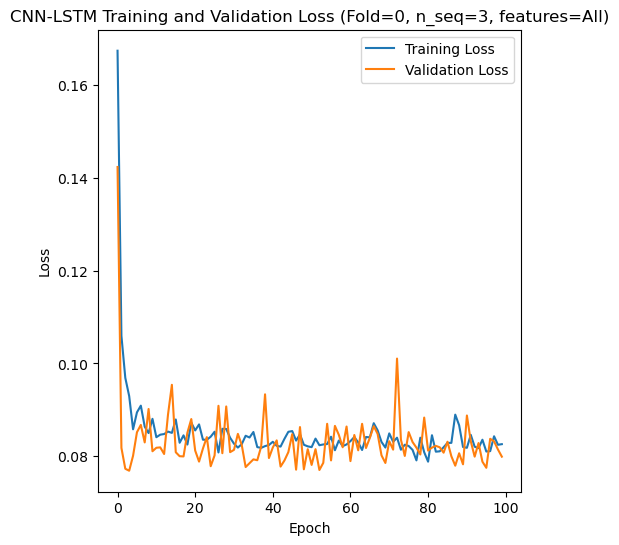

Epoch 1/100
84/84 [==============================] - 25s 126ms/step - loss: 0.1586 - accuracy: 0.8333 - mae: 0.1337 - rmse: 0.1586 - mape: 24.6992 - pearson: 0.7676 - val_loss: 0.1630 - val_accuracy: 0.9000 - val_mae: 0.1534 - val_rmse: 0.1630 - val_mape: 31.7570 - val_pearson: 0.7322
Epoch 2/100
84/84 [==============================] - 7s 81ms/step - loss: 0.1070 - accuracy: 0.9048 - mae: 0.0925 - rmse: 0.1070 - mape: 17.4288 - pearson: 0.8661 - val_loss: 0.1530 - val_accuracy: 0.9000 - val_mae: 0.1268 - val_rmse: 0.1530 - val_mape: 20.4268 - val_pearson: 0.8480
Epoch 3/100
84/84 [==============================] - 6s 75ms/step - loss: 0.1107 - accuracy: 0.9048 - mae: 0.0943 - rmse: 0.1107 - mape: 17.5257 - pearson: 0.8658 - val_loss: 0.1515 - val_accuracy: 0.9000 - val_mae: 0.1278 - val_rmse: 0.1515 - val_mape: 21.3972 - val_pearson: 0.8615
Epoch 4/100
84/84 [==============================] - 7s 80ms/step - loss: 0.0881 - accuracy: 0.9048 - mae: 0.0759 - rmse: 0.0881 - mape: 14.0478 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 6s 66ms/step - loss: 0.0786 - accuracy: 0.9524 - mae: 0.0687 - rmse: 0.0786 - mape: 13.3347 - pearson: 0.9055 - val_loss: 0.1000 - val_accuracy: 0.8000 - val_mae: 0.0835 - val_rmse: 0.1000 - val_mape: 17.3362 - val_pearson: 0.8115
Epoch 93/100
84/84 [==============================] - 5s 65ms/step - loss: 0.0811 - accuracy: 0.9524 - mae: 0.0695 - rmse: 0.0811 - mape: 13.4889 - pearson: 0.9064 - val_loss: 0.0955 - val_accuracy: 0.8000 - val_mae: 0.0822 - val_rmse: 0.0955 - val_mape: 18.3202 - val_pearson: 0.8102
Epoch 94/100
84/84 [==============================] - 6s 66ms/step - loss: 0.0789 - accuracy: 0.9524 - mae: 0.0689 - rmse: 0.0789 - mape: 13.3102 - pearson: 0.9070 - val_loss: 0.0995 - val_accuracy: 0.8000 - val_mae: 0.0830 - val_rmse: 0.0995 - val_mape: 18.0986 - val_pearson: 0.7860
Epoch 95/100
84/84 [==============================] - 6s 67ms/step - loss: 0.0790 - accuracy: 0.9524 - mae: 0.0691 - rmse: 0.0790 - mape: 13.3514 - pearson: 0

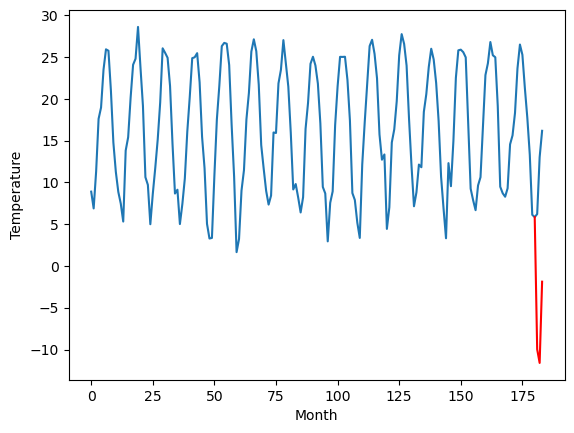

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.42		7.84		-0.58
4.70		6.21		1.51
16.67		15.94		-0.73
[180, 181, 182, 183]
[3.2, 7.835976428985596, 6.213618226051331, 15.935280747413636]


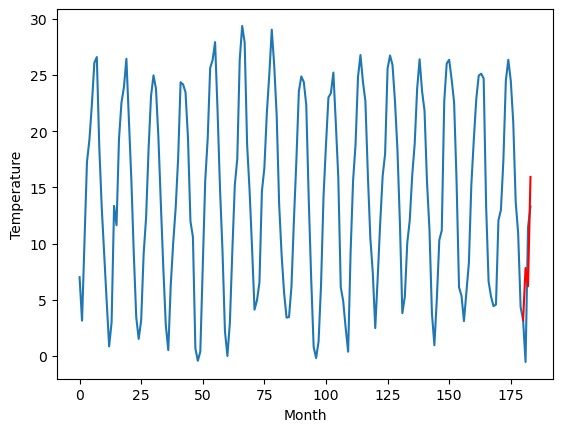

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.30		7.31		-2.99
12.60		5.68		-6.92
13.75		15.41		1.66
[180, 181, 182, 183]
[8.48, 7.305976428985595, 5.683617272377013, 15.405275979042052]


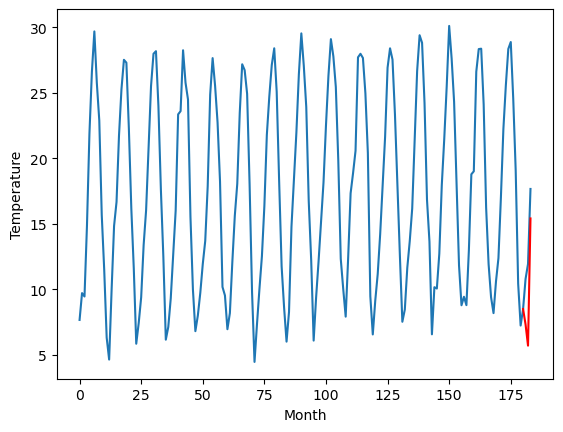

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.74		1.47		-0.27
0.42		-0.16		-0.58
10.63		9.57		-1.06
[180, 181, 182, 183]
[1.55, 1.4659783363342287, -0.15637700557708722, 9.565285515785217]


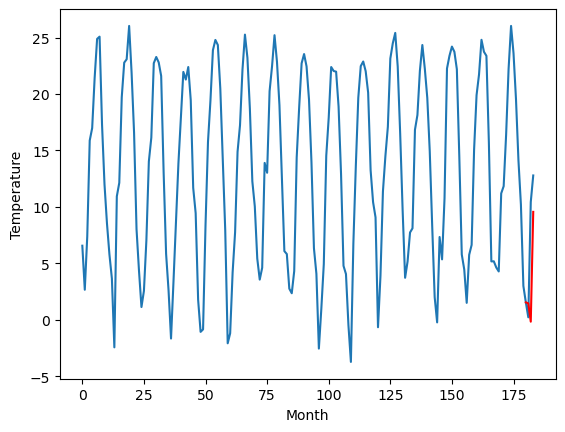

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.43		7.17		-0.26
3.56		5.54		1.98
16.64		15.27		-1.37
[180, 181, 182, 183]
[1.08, 7.165978336334229, 5.54362108707428, 15.265283608436585]


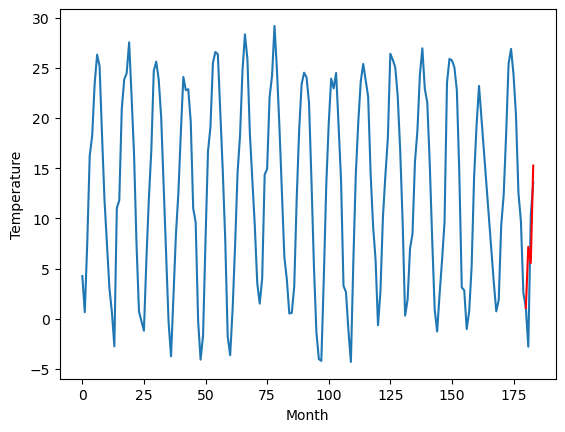

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.57		5.29		-0.28
2.85		3.66		0.81
14.18		13.39		-0.79
[180, 181, 182, 183]
[0.21, 5.285978336334228, 3.663620133399963, 13.385282654762268]


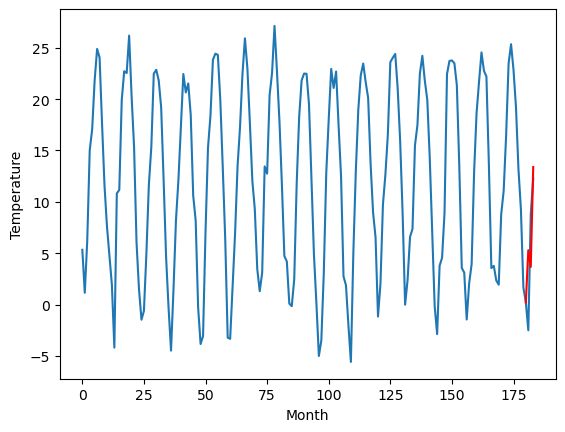

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.92		5.92		-2.00
8.02		4.29		-3.73
10.99		14.02		3.03
[180, 181, 182, 183]
[-8.22, 5.9159773826599125, 4.293619179725647, 14.015281701087952]


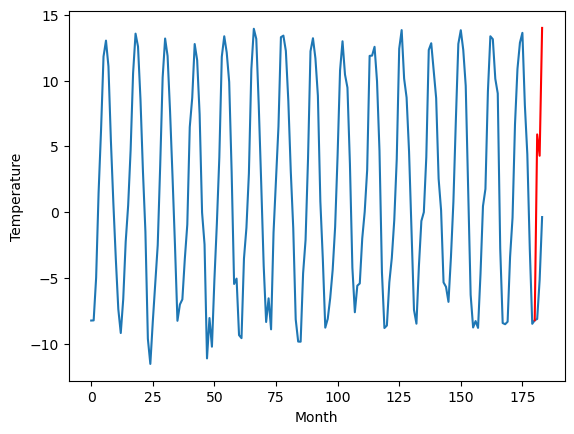

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.12		4.84		-2.28
9.97		3.21		-6.76
11.57		12.94		1.37
[180, 181, 182, 183]
[10.04, 4.835976428985596, 3.2136153650283816, 12.935270256996155]


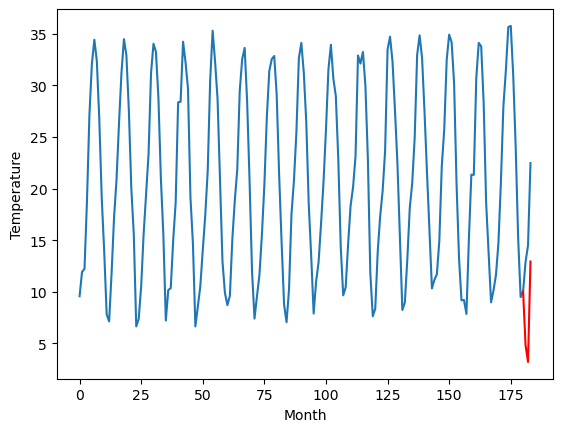

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.47		2.52		-2.95
6.40		0.89		-5.51
6.18		10.62		4.44
[180, 181, 182, 183]
[9.17, 2.5159764289855957, 0.8936172723770142, 10.615272164344788]


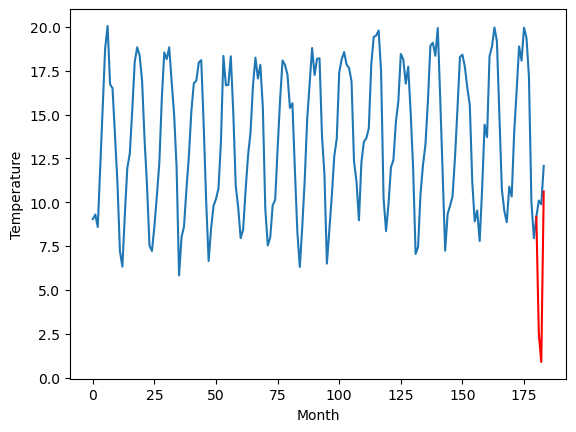

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.31		3.60		1.29
2.19		1.97		-0.22
7.19		11.70		4.51
[180, 181, 182, 183]
[0.94, 3.595979290008545, 1.9736249017715455, 11.695291237831116]


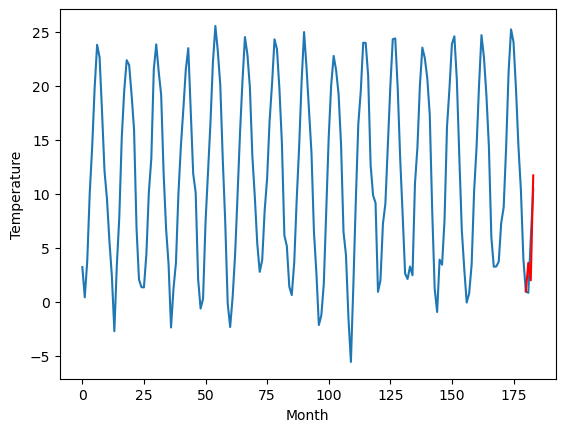

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-9.80		-9.97		-0.17
-10.60		-11.60		-1.00
-3.41		-1.87		1.54
[180, 181, 182, 183]
[-0.13, -9.974021663665772, -11.596376051902771, -1.874709715843201]


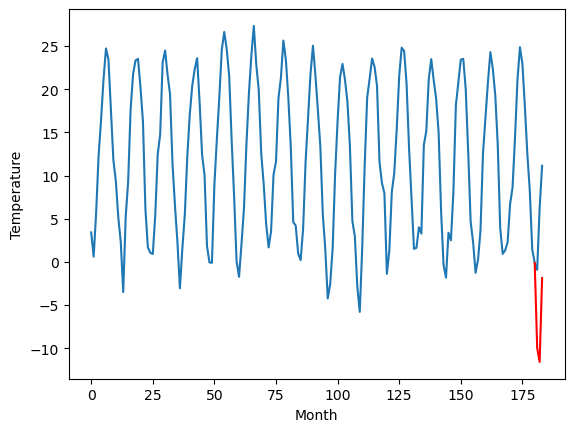

RangeIndex(start=1, stop=12, step=1)
[-8.520000000000001, 8.420000000000002, 10.299999999999999, 1.7399999999999998, 7.430000000000001, 5.5699999999999985, 7.92, 7.119999999999999, 5.4700000000000015, 2.3099999999999996, -9.8]
[-9.974023571014405, 7.835976428985596, 7.305976428985595, 1.4659783363342287, 7.165978336334229, 5.285978336334228, 5.9159773826599125, 4.835976428985596, 2.5159764289855957, 3.595979290008545, -9.974021663665772]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   -8.52  -9.974024
1                 1    8.42   7.835976
2                 2   10.30   7.305976
3                 3    1.74   1.465978
4                 4    7.43   7.165978
5                 5    5.57   5.285978
6                 6    7.92   5.915977
7                 7    7.12   4.835976
8                 8    5.47   2.515976
9                 9    2.31   3.595979
10               10   -9.80  -9.974022


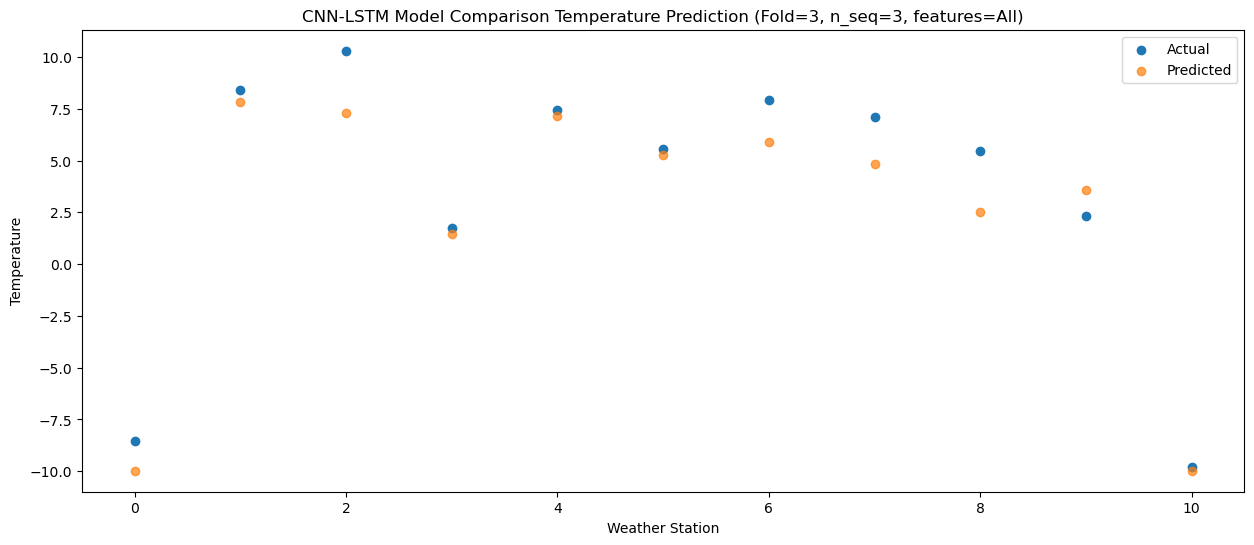

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0   -8.15 -11.596382
1                 1    4.70   6.213618
2                 2   12.60   5.683617
3                 3    0.42  -0.156377
4                 4    3.56   5.543621
5                 5    2.85   3.663620
6                 6    8.02   4.293619
7                 7    9.97   3.213615
8                 8    6.40   0.893617
9                 9    2.19   1.973625
10               10  -10.60 -11.596376


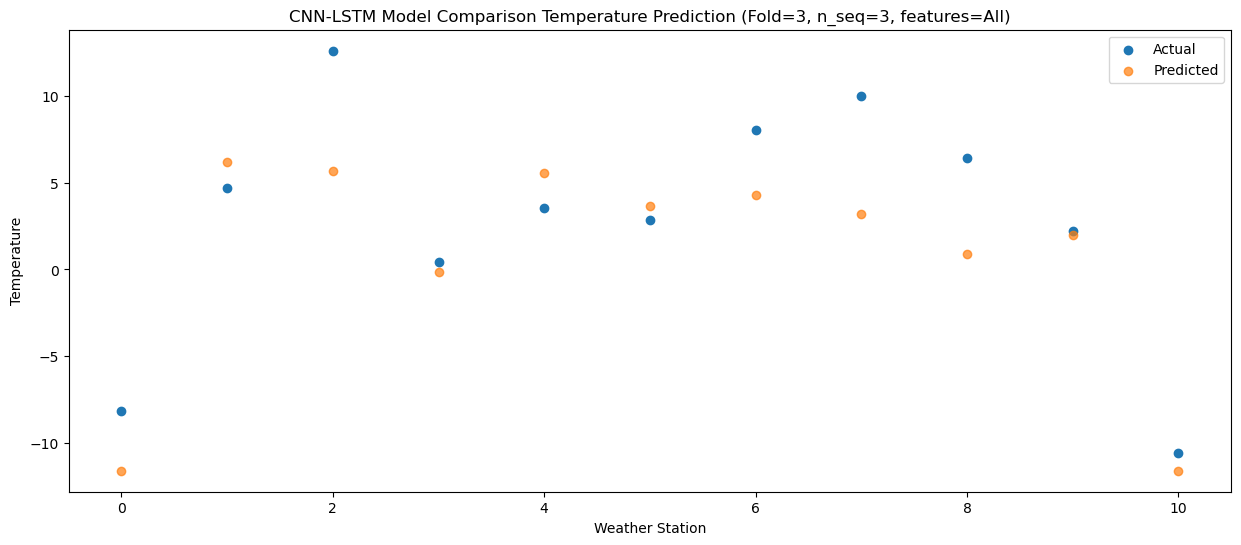

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   -1.35  -1.874719
1                 1   16.67  15.935281
2                 2   13.75  15.405276
3                 3   10.63   9.565286
4                 4   16.64  15.265284
5                 5   14.18  13.385283
6                 6   10.99  14.015282
7                 7   11.57  12.935270
8                 8    6.18  10.615272
9                 9    7.19  11.695291
10               10   -3.41  -1.874710


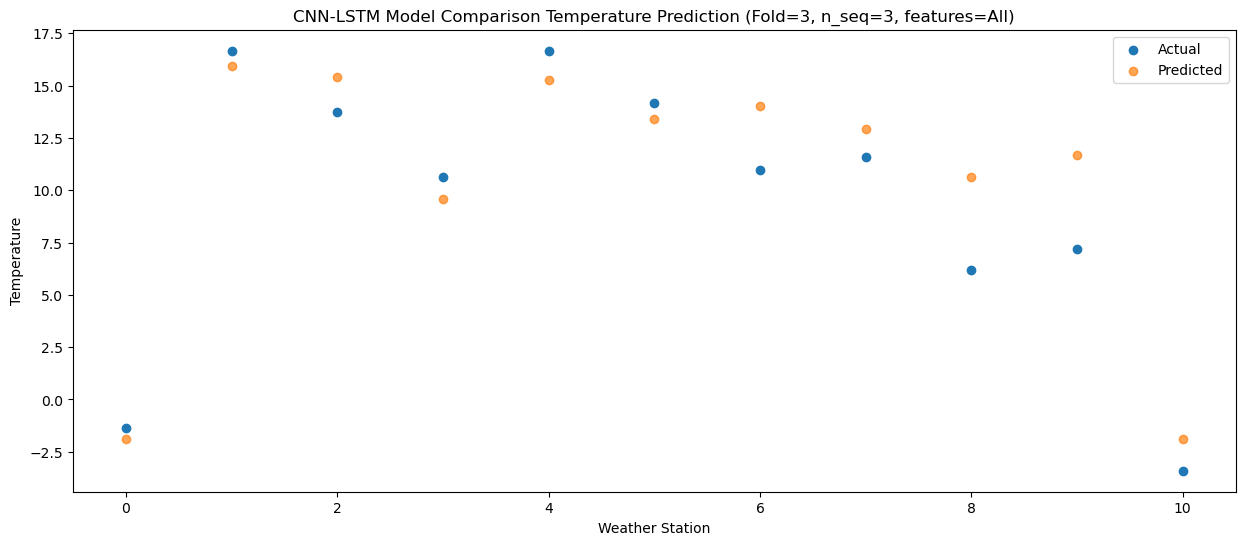

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 256)            550144    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 dropout_24 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 512)            1574912   
                                                                 
 dropout_25 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_17 (LSTM)              (None, 512)               2099200   
                                                      

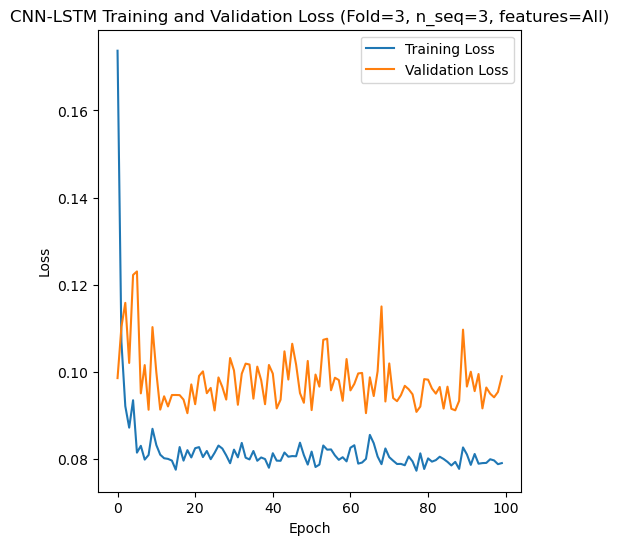

Epoch 1/100
84/84 [==============================] - 34s 143ms/step - loss: 0.1567 - accuracy: 0.7619 - mae: 0.1384 - rmse: 0.1567 - mape: 25.4041 - pearson: 0.7101 - val_loss: 0.1428 - val_accuracy: 1.0000 - val_mae: 0.1219 - val_rmse: 0.1428 - val_mape: 28.1440 - val_pearson: 0.8654
Epoch 2/100
84/84 [==============================] - 5s 63ms/step - loss: 0.1040 - accuracy: 0.9048 - mae: 0.0890 - rmse: 0.1040 - mape: 16.8036 - pearson: 0.8605 - val_loss: 0.0972 - val_accuracy: 1.0000 - val_mae: 0.0863 - val_rmse: 0.0972 - val_mape: 16.9577 - val_pearson: 0.9447
Epoch 3/100
84/84 [==============================] - 5s 62ms/step - loss: 0.1000 - accuracy: 0.9048 - mae: 0.0855 - rmse: 0.1000 - mape: 15.9723 - pearson: 0.8477 - val_loss: 0.1025 - val_accuracy: 1.0000 - val_mae: 0.0876 - val_rmse: 0.1025 - val_mape: 18.2012 - val_pearson: 0.9274
Epoch 4/100
84/84 [==============================] - 6s 66ms/step - loss: 0.0862 - accuracy: 0.9048 - mae: 0.0744 - rmse: 0.0862 - mape: 13.8696 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 7s 87ms/step - loss: 0.0820 - accuracy: 0.9048 - mae: 0.0707 - rmse: 0.0820 - mape: 13.3045 - pearson: 0.8710 - val_loss: 0.1048 - val_accuracy: 1.0000 - val_mae: 0.0906 - val_rmse: 0.1048 - val_mape: 17.3449 - val_pearson: 0.9460
Epoch 57/100
84/84 [==============================] - 7s 79ms/step - loss: 0.0792 - accuracy: 0.9048 - mae: 0.0680 - rmse: 0.0792 - mape: 12.8311 - pearson: 0.8748 - val_loss: 0.1020 - val_accuracy: 1.0000 - val_mae: 0.0883 - val_rmse: 0.1020 - val_mape: 16.5427 - val_pearson: 0.9546
Epoch 58/100
84/84 [==============================] - 6s 73ms/step - loss: 0.0782 - accuracy: 0.9048 - mae: 0.0672 - rmse: 0.0782 - mape: 12.6458 - pearson: 0.8766 - val_loss: 0.0998 - val_accuracy: 1.0000 - val_mae: 0.0867 - val_rmse: 0.0998 - val_mape: 17.0328 - val_pearson: 0.9510
Epoch 59/100
84/84 [==============================] - 5s 61ms/step - loss: 0.0799 - accuracy: 0.9048 - mae: 0.0686 - rmse: 0.0799 - mape: 12.8020 - pearson: 0

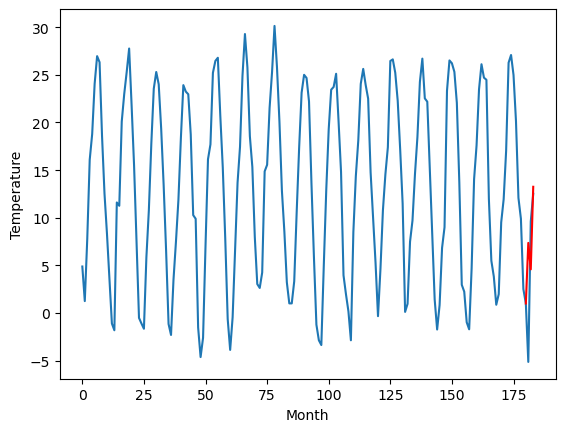

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.34		5.69		-2.65
11.77		2.91		-8.86
13.37		11.57		-1.80
[180, 181, 182, 183]
[14.25, 5.6862830066680905, 2.909092798233032, 11.57371319770813]


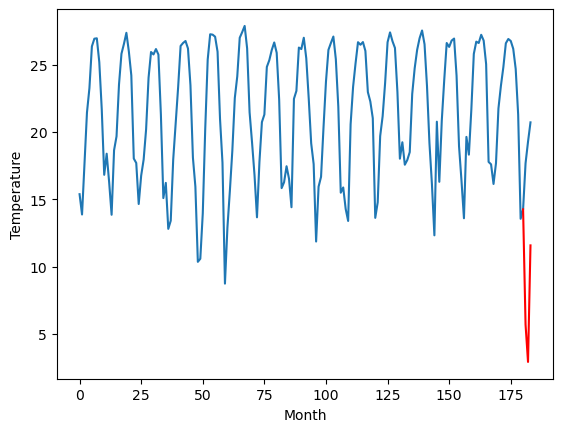

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		2.31		-1.98
2.37		-0.47		-2.84
11.70		8.19		-3.51
[180, 181, 182, 183]
[9.06, 2.306303629875183, -0.4708689355850222, 8.193733344078064]


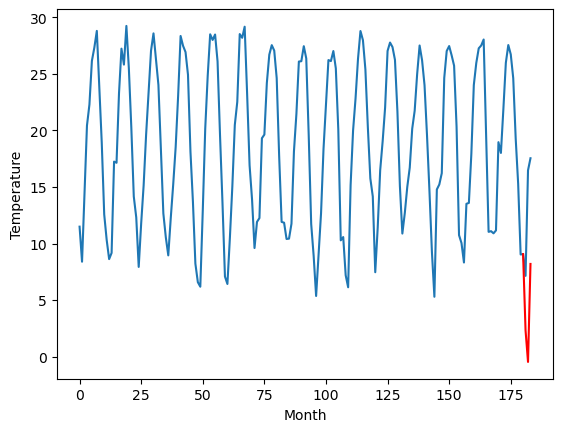

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.70		1.67		-1.03
-0.76		-1.11		-0.35
10.20		7.55		-2.65
[180, 181, 182, 183]
[7.48, 1.6663340282440187, -1.1108168411254882, 7.553773994445801]


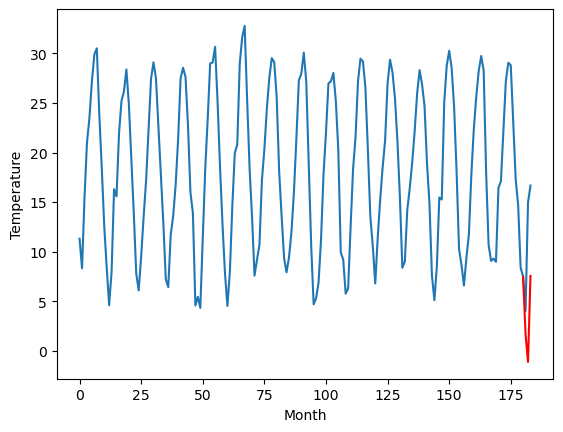

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		2.94		-1.35
0.40		0.16		-0.24
11.32		8.82		-2.50
[180, 181, 182, 183]
[7.33, 2.9363418960571286, 0.15919293403625456, 8.823783769607545]


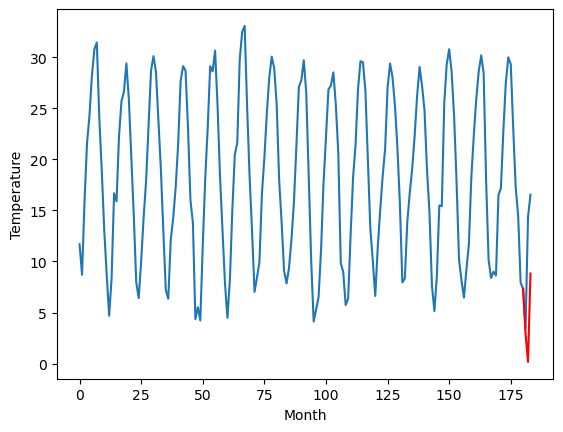

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.28		13.43		-0.85
12.71		10.65		-2.06
21.96		19.31		-2.65
[180, 181, 182, 183]
[6.59, 13.426334981918336, 10.649181966781617, 19.313772802352908]


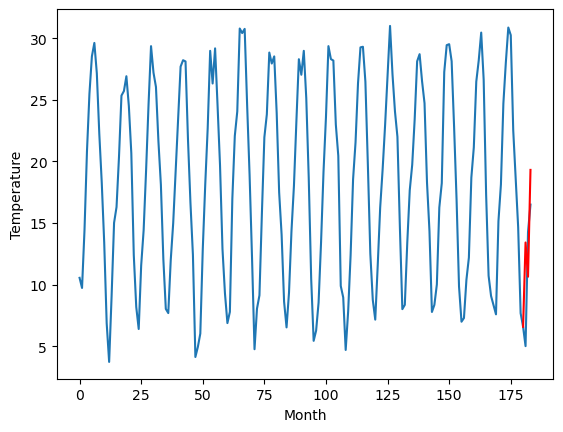

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.72		9.54		-2.18
12.39		6.76		-5.63
18.79		15.42		-3.37
[180, 181, 182, 183]
[6.04, 9.53629385471344, 6.759109606742859, 15.423723330497742]


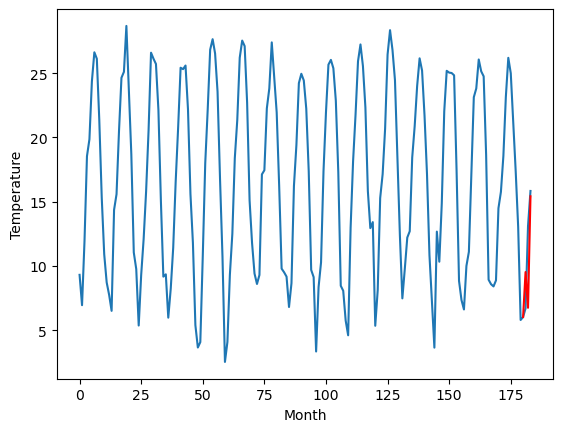

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.64		9.36		-0.28
6.03		6.58		0.55
18.30		15.24		-3.06
[180, 181, 182, 183]
[3.13, 9.356325206756592, 6.579164562225342, 15.24376111984253]


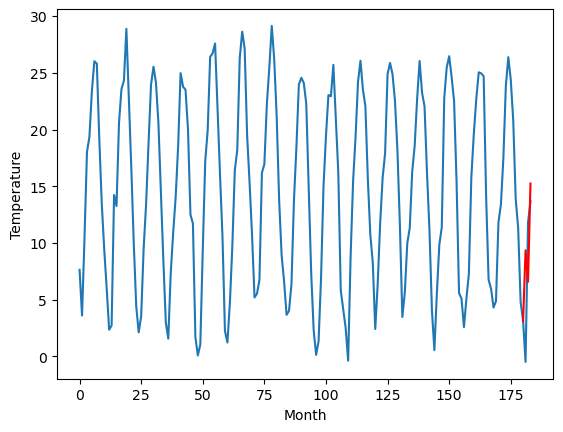

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.11		9.74		-0.37
6.75		6.96		0.21
18.72		15.62		-3.10
[180, 181, 182, 183]
[-0.29, 9.736324253082275, 6.959163608551025, 15.62375825881958]


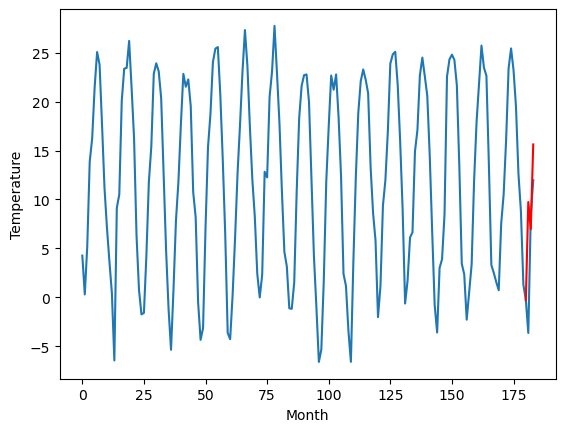

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		8.61		0.08
4.09		5.83		1.74
17.95		14.49		-3.46
[180, 181, 182, 183]
[-1.03, 8.606346783638001, 5.8292037820816045, 14.493786988258362]


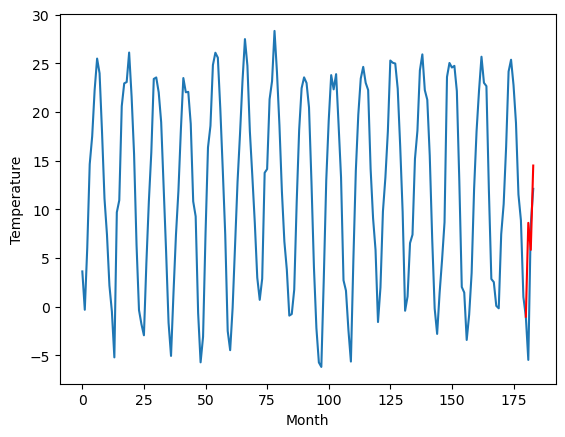

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.40		7.37		-0.03
5.16		4.59		-0.57
15.05		13.25		-1.80
[180, 181, 182, 183]
[-2.29, 7.366334981918335, 4.5891819667816165, 13.253772802352906]


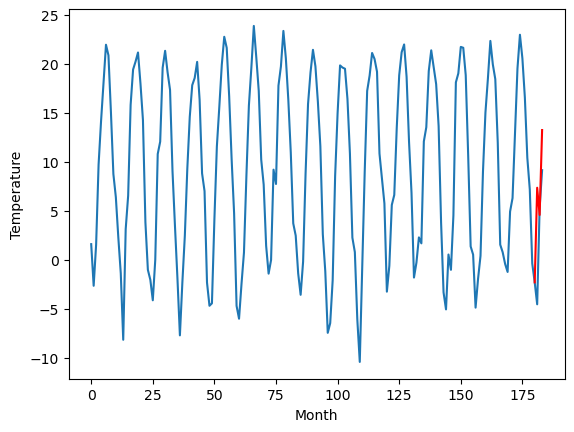

RangeIndex(start=1, stop=12, step=1)
[7.810000000000001, 8.339999999999998, 4.290000000000002, 2.7000000000000006, 4.289999999999999, 14.280000000000001, 11.719999999999999, 9.64, 10.11, 8.53, 7.4]
[7.366352624893189, 5.6862830066680905, 2.306303629875183, 1.6663340282440187, 2.9363418960571286, 13.426334981918336, 9.53629385471344, 9.356325206756592, 9.736324253082275, 8.606346783638001, 7.366334981918335]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.81   7.366353
1                 1    8.34   5.686283
2                 2    4.29   2.306304
3                 3    2.70   1.666334
4                 4    4.29   2.936342
5                 5   14.28  13.426335
6                 6   11.72   9.536294
7                 7    9.64   9.356325
8                 8   10.11   9.736324
9                 9    8.53   8.606347
10               10    7.40   7.366335


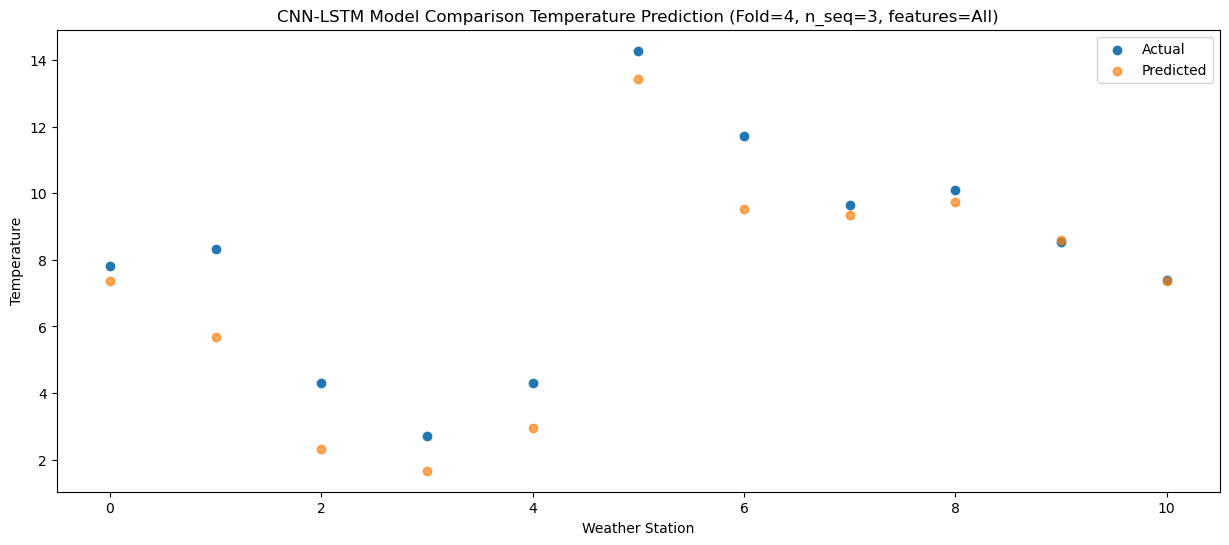

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    1.68   4.589213
1                 1   11.77   2.909093
2                 2    2.37  -0.470869
3                 3   -0.76  -1.110817
4                 4    0.40   0.159193
5                 5   12.71  10.649182
6                 6   12.39   6.759110
7                 7    6.03   6.579165
8                 8    6.75   6.959164
9                 9    4.09   5.829204
10               10    5.16   4.589182


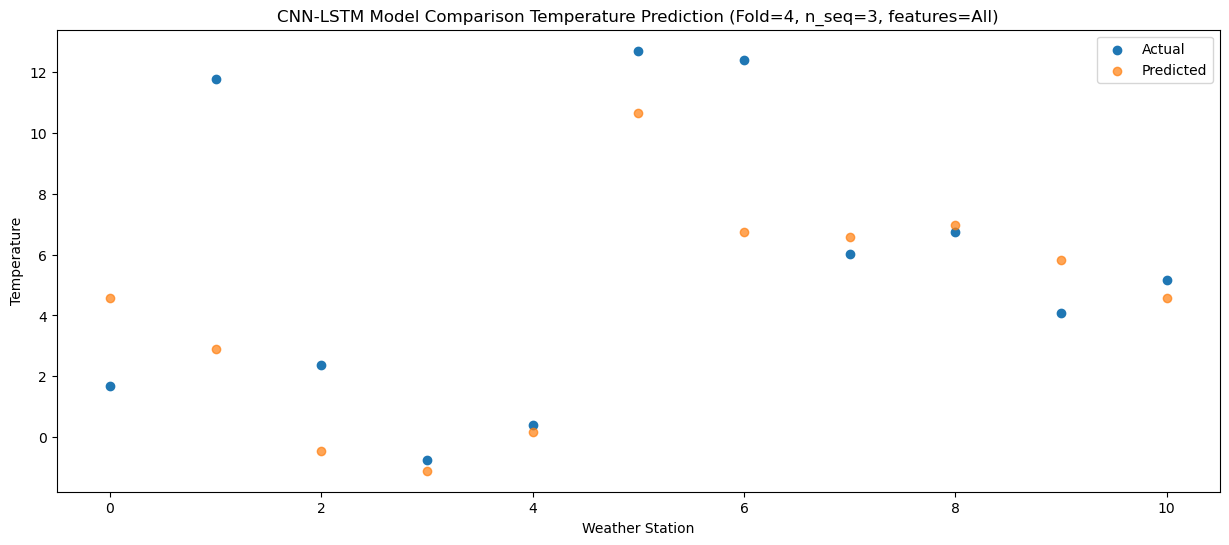

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   16.41  13.253792
1                 1   13.37  11.573713
2                 2   11.70   8.193733
3                 3   10.20   7.553774
4                 4   11.32   8.823784
5                 5   21.96  19.313773
6                 6   18.79  15.423723
7                 7   18.30  15.243761
8                 8   18.72  15.623758
9                 9   17.95  14.493787
10               10   15.05  13.253773


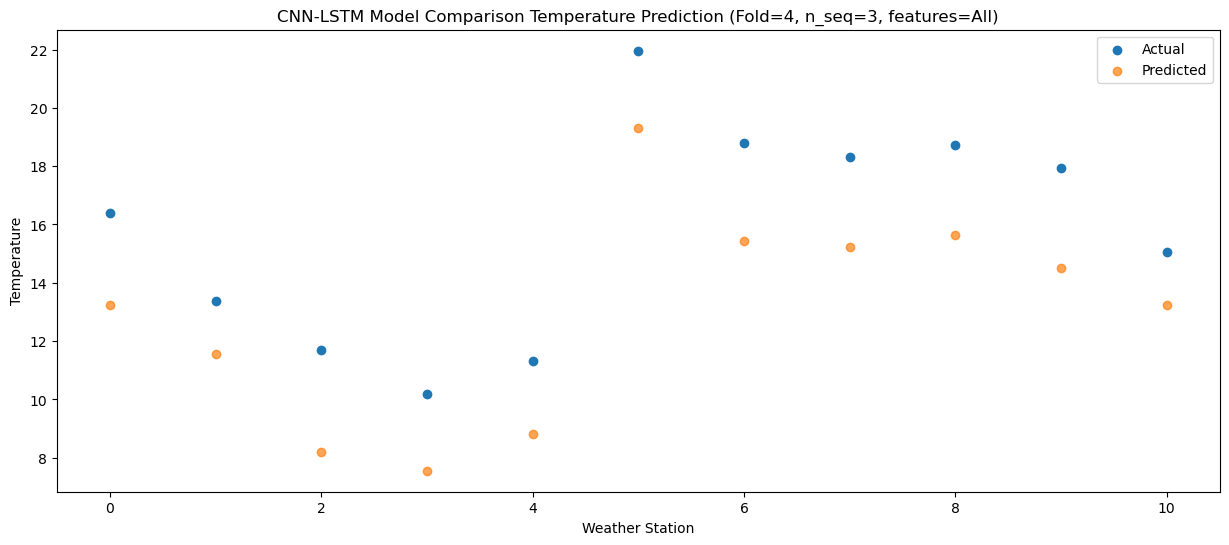

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1, 256)            550144    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 dropout_27 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 512)            1574912   
                                                                 
 dropout_28 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_19 (LSTM)              (None, 512)               2099200   
                                                      

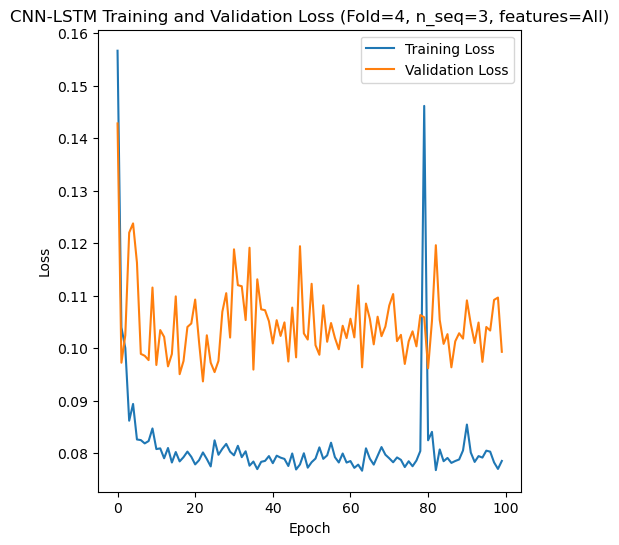

[[1.2163886083079647, 3.260542554196222, 1.570470613406254], [0.8465677829972725, 2.71918686052402, 1.2730737713980893], [1.2109630845612835, 3.0315797132116535, 6.893758310380353], [1.6865257643628002, 3.787879711641426, 2.346231326299357], [1.3416179979124834, 3.5016968330392086, 2.8785933424093586]]
[[0.9367947144941852, 2.606098514903676, 1.4375244868885395], [0.8065124429355964, 2.2959655059467665, 1.0268306810205639], [0.7809953185645011, 2.629046095501293, 6.310846746184609], [1.323291492462158, 2.9501727533340447, 1.9104789408770473], [1.0248289381374014, 2.360242899547923, 2.8198753196542907]]
[[0.11763770755813628, 0.35052621067863265, 0.08865698790592492], [0.08595625704265993, 0.2588104922261612, 0.05887808593865874], [0.10680570267484116, 0.4558223009303914, 0.46992520923913744], [0.22391228692895, 0.5185743144059339, 0.27088687618444923], [0.169251359710297, 0.5473944366111582, 0.18638838864210847]]
[[0.7634024584640274, 0.03149579877053521, 0.6706104607406032], [0.890453

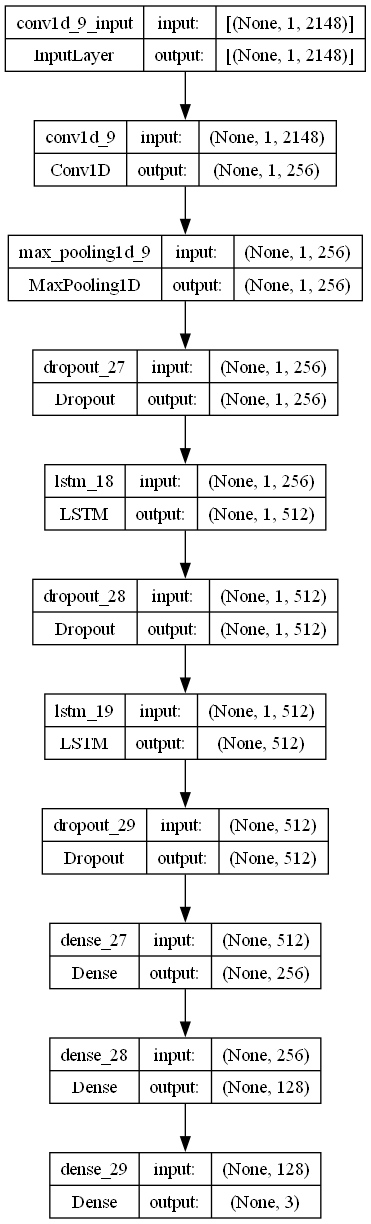

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.001431634964858197
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.12576068505893612

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with a CNN-LSTM model,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S3.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)